<a href="https://colab.research.google.com/github/therobinkay/gender_bias_2021/blob/main/Journal_Analysis_2_(GitHub).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import io
import pandas as pd
import os
import itertools
import numpy as np
import scipy.stats
# import time

import matplotlib.pyplot as plt
import seaborn as sns

import statistics
import math

# from tqdm.auto import tqdm

# import networkx as nx
from random import randint

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
!cd "drive/My Drive"

In [ ]:
data = pd.read_csv("drive/My Drive/codes/data.csv")
# dp = pd.read_csv("drive/My Drive/codes/doipacs.csv")

cb = pd.read_csv("drive/My Drive/codes/citationBara.csv")
cb['pair'] = "(" + cb["citing_doi"] + ", " + cb["cited_doi"] + ")"
cb['pair2'] = "(" + cb["cited_doi"] + ", " + cb["citing_doi"] + ")"

# 0'. Manual Similarity Validation

In [ ]:
pair = pd.read_csv("drive/My Drive/codes/pairdata.csv")

# m = pair['year1'] > pair['year2']

# pair.loc[m, ['paper1', 'gender1', 'year1', 'paper2', 'gender2', 'year2']] = (
#     pair.loc[m, ['paper2', 'gender2', 'year2', 'paper1', 'gender1', 'year1']].values)

# pair.to_csv("drive/My Drive/codes/pairdata.csv", index=False)

In [ ]:
pair[pair['qval'] < 0.0000001]

,paper1,gender1,year1,paper2,gender2,year2,qval,k
23630,10.1103/PhysRevB.35.197,male,1987,10.1103/PhysRevB.43.11274,male,1991,1.120640e-08,False
24553,10.1103/PhysRevA.40.5905,male,1989,10.1103/PhysRevA.43.663,male,1991,2.819833e-08,True
49118,10.1103/PhysRevA.68.063406,male,2003,10.1103/PhysRevA.74.053417,male,2006,3.209790e-08,True
57341,10.1103/PhysRevA.78.063811,male,2008,10.1103/PhysRevA.80.052105,male,2009,8.043679e-10,True
95218,10.1103/PhysRevE.70.045101,male,2004,10.1103/PhysRevE.70.056133,male,2004,1.060378e-10,False
...,...,...,...,...,...,...,...,...
5747607,10.1103/PhysRevE.79.051801,male,2009,10.1103/PhysRevE.80.051805,female,2009,6.717853e-08,True
5748356,10.1103/PhysRevE.78.051922,female,2008,10.1103/PhysRevE.79.021905,male,2009,2.116915e-08,False
5752261,10.1103/PhysRevE.73.020901,male,2006,10.1103/PhysRevE.73.041802,male,2006,8.015693e-08,True
5778076,10.1103/PhysRevD.60.104040,male,1999,10.1103/PhysRevD.69.084018,male,2004,6.411863e-08,True


In [ ]:
pair[pair['paper1'] == "10.1103/PhysRevA.40.5905"].sort_values("qval")

In [ ]:
a1 = pair[pair['paper2'] == '10.1103/PhysRevA.40.5905'].sort_values(['year1', 'paper1', 'qval'])
b1 = pair[pair['paper1'] == '10.1103/PhysRevA.40.5905'].sort_values(['year1', 'paper1', 'qval'])
print(len(a1))
print(len(b1))

16
37


In [ ]:
a2 = pair[pair['paper2'] == '10.1103/PhysRevA.43.663'].sort_values(['year1', 'paper1', 'qval'])
b2 = pair[pair['paper1'] == '10.1103/PhysRevA.43.663'].sort_values(['year1', 'paper1', 'qval'])
print(len(a2))
print(len(b2))

44
17


In [ ]:
s1 = a1.merge(a2, how='inner', on=['paper1'])
s2 = b1.merge(b2, how='inner', on=['paper2'])
print(len(s1))
print(len(s2))

16
15


# 0. Mega Dataset Setup (For 1c)

In [ ]:
fout=open("drive/My Drive/codes/initpair.csv","a")
# first file:
for line in open("drive/My Drive/codes/hom0.csv"):
    fout.write(line)
# now the rest:    
for num in range(1,10):
    f = open("drive/My Drive/codes/hom"+str(num)+".csv")
    f.__next__() # skip the header
    for line in f:
         fout.write(line)
    f.close() # not really needed
fout.close()

In [ ]:
initpair = pd.read_csv("drive/My Drive/codes/initpair.csv")

In [ ]:
print(len(initpair))
initpair.head()

6045172


,paper1,gender1,year1,paper2,gender2,year2,qval,k
0,10.1103/PhysRevA.30.336,male,1984,10.1103/PhysRevA.34.1617,male,1986,0.001230,False
1,10.1103/PhysRevA.30.336,male,1984,10.1103/PhysRevA.34.4472,female,1986,0.017857,False
2,10.1103/PhysRevA.30.336,male,1984,10.1103/PhysRevA.41.784,male,1990,0.017857,False
3,10.1103/PhysRevA.34.4472,female,1986,10.1103/PhysRevA.41.784,male,1990,0.017857,False
4,10.1103/PhysRevA.36.4950,female,1987,10.1103/PhysRevA.41.784,male,1990,0.006410,False


In [ ]:
pairdata = initpair.drop_duplicates()
print(len(pairdata))
pairdata.head()

5856207


,paper1,gender1,year1,paper2,gender2,year2,qval,k
0,10.1103/PhysRevA.30.336,male,1984,10.1103/PhysRevA.34.1617,male,1986,0.001230,False
1,10.1103/PhysRevA.30.336,male,1984,10.1103/PhysRevA.34.4472,female,1986,0.017857,False
2,10.1103/PhysRevA.30.336,male,1984,10.1103/PhysRevA.41.784,male,1990,0.017857,False
3,10.1103/PhysRevA.34.4472,female,1986,10.1103/PhysRevA.41.784,male,1990,0.017857,False
4,10.1103/PhysRevA.36.4950,female,1987,10.1103/PhysRevA.41.784,male,1990,0.006410,False


In [ ]:
pairdata.to_csv("drive/My Drive/codes/pairdata.csv", index=False)

# 1. Year Diff. vs. Centrality Diff.

In [ ]:
homn = pd.read_csv("drive/My Drive/codes/pairdata.csv")
# homn.head()

In [ ]:
############## SELECT DESIRED PACS (HOMOPHILY ONLY) ###############

# homn = pd.read_csv("drive/My Drive/codes/hom0.csv")
# homn = pd.read_csv("drive/My Drive/codes/hom1.csv")
# homn = pd.read_csv("drive/My Drive/codes/hom2.csv")
# homn = pd.read_csv("drive/My Drive/codes/hom3.csv")
# homn = pd.read_csv("drive/My Drive/codes/hom4.csv")
# homn = pd.read_csv("drive/My Drive/codes/hom5.csv")
# homn = pd.read_csv("drive/My Drive/codes/hom6.csv")
# homn = pd.read_csv("drive/My Drive/codes/hom7.csv")
# homn = pd.read_csv("drive/My Drive/codes/hom8.csv")
homn = pd.read_csv("drive/My Drive/codes/hom9.csv")

print(len(homn))
homn.head()

103313


,paper1,gender1,year1,paper2,gender2,year2,qval,k
0,10.1103/PhysRevA.35.4035,male,1987,10.1103/PhysRevA.36.4163,male,1987,0.001441,False
1,10.1103/PhysRevA.36.4700,male,1987,10.1103/PhysRevA.38.1839,male,1988,0.003817,True
2,10.1103/PhysRevA.36.4700,male,1987,10.1103/PhysRevA.40.6260,male,1989,0.003817,True
3,10.1103/PhysRevA.38.1839,male,1988,10.1103/PhysRevA.40.6260,male,1989,0.000015,True
4,10.1103/PhysRevA.36.4700,male,1987,10.1103/PhysRevA.40.6931,male,1989,0.003817,True


In [ ]:
dc = data[["doi", "year"]].drop_duplicates(subset = 'doi')
dc = dc.merge(cb, left_on = 'doi',
              right_on = 'citing_doi', how = 'inner').drop(
                  ['doi'], axis=1).rename({'year': 'citing_year'}, axis=1)

cols = ['citing_doi', 'citing_year', 'cited_doi']
dc = dc.reindex(columns=cols).sort_values('cited_doi')

In [ ]:
hom_mf = homn[homn["gender1"] != homn["gender2"]].reset_index(drop=True)

test = hom_mf.merge(dc, left_on = 'paper1',
                    right_on = 'cited_doi', how = 'left').drop(
                        ["cited_doi", "citing_year"], axis=1).drop_duplicates(
                            subset=['paper1', 'citing_doi'])
test['count'] = test.groupby(['paper1'])['paper1'].transform('count')
test = test.drop(["citing_doi"], axis=1).rename({'count': 'count1'}, axis=1)

test = test.drop_duplicates(subset=['paper1', 'paper2']).drop(
    ['gender1', 'year1', 'paper2', 'gender2', 'year2', 'qval', 'k'], axis=1)
hom_mf = hom_mf.merge(test, on='paper1', how='inner')

test = hom_mf.merge(dc, left_on = 'paper2',
                    right_on = 'cited_doi', how = 'left').drop(
                        ["cited_doi", "citing_year"], axis=1).drop_duplicates(
                            subset=['paper2', 'citing_doi'])
test['count'] = test.groupby(['paper2'])['paper2'].transform('count')
test = test.drop(["citing_doi"], axis=1).rename(
    {'count': 'count2'}, axis=1).drop_duplicates(
        subset=['paper1', 'paper2']).drop(
            ['gender1', 'year1', 'paper1', 'gender2', 'count1',
             'year2', 'qval', 'k'], axis=1)
hom_mf = hom_mf.merge(test, on='paper2', how='inner')

del test

# print(len(hom_mf))
# print(hom_mf['paper1'].nunique())
# hom_mf.head()

In [ ]:
listd = []
listy = []

for c in range(len(hom_mf)):
  if hom_mf['gender1'][c] == 'male':
    listd.append(hom_mf['count1'][c] - hom_mf['count2'][c])
    listy.append(hom_mf['year1'][c] - hom_mf['year2'][c])
  else:
    listd.append(hom_mf['count2'][c] - hom_mf['count1'][c])
    listy.append(hom_mf['year2'][c] - hom_mf['year1'][c])

hom_mf['countd'] = listd
hom_mf['yeard'] = listy

# print(len(hom_mf))
# hom_mf.head()

In [ ]:
hom_mf = hom_mf.sort_values('qval').drop_duplicates(subset=['paper1', 'paper2'], keep='first')
# print(len(hom_mf))
# hom_mf.head()

In [ ]:
# use p-values from the paper
p = 0.006

homp = hom_mf[hom_mf['qval'] < p].sort_values('countd').reset_index(drop=True)
len(homp)/len(hom_mf)

0.05549040511727079

In [ ]:
block12 = homp[homp['countd'] > 0]
block34 = homp[homp['countd'] < 0]

block1 = block12[block12['yeard'] > 0]
block2 = block12[block12['yeard'] < 0]
block3 = block34[block34['yeard'] < 0]
block4 = block34[block34['yeard'] > 0]

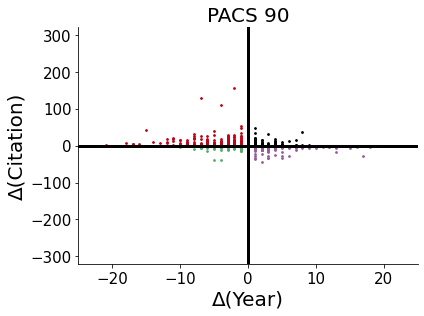

In [ ]:
# build scatterplots

fig, ax = plt.subplots(figsize=(6,4.5))
right_side = ax.spines["right"]
top_side = ax.spines["top"]
right_side.set_visible(False)
top_side.set_visible(False)

plt.title("PACS 90", fontsize=20)
plt.scatter(block1.yeard, block1.countd, s=3, c='#000000')
plt.scatter(block2.yeard, block2.countd, s=3, c='#c20114')
plt.scatter(block3.yeard, block3.countd, s=3, c='#59a96a')
plt.scatter(block4.yeard, block4.countd, s=3, c='#985f99')
plt.axhline(y=0, linewidth=0.5, c='k', lw=3)
plt.axvline(x=0, linewidth=0.5, c='k', lw=3)
plt.xlabel("\u0394(Year)", fontsize=20)
plt.ylabel("\u0394(Citation)", fontsize=20)
plt.ylim(ymin=-320, ymax=320)
plt.xlim(xmin=-25, xmax=25)

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.tight_layout()
fig.savefig("drive/My Drive/codes/scatter90.pdf")

In [ ]:
# block12 = homp[homp['yeard'] > 0]
# block34 = homp[homp['yeard'] < 0]

# block1 = block12[block12['countd'] > 0]
# block2 = block12[block12['countd'] < 0]
# block3 = block34[block34['countd'] < 0]
# block4 = block34[block34['countd'] > 0]

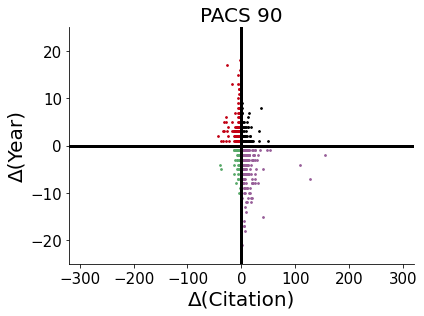

In [ ]:
# # build scatterplots

# fig, ax = plt.subplots(figsize=(6,4.5))
# right_side = ax.spines["right"]
# top_side = ax.spines["top"]
# right_side.set_visible(False)
# top_side.set_visible(False)

# plt.title("PACS 00", fontsize=20)
# plt.scatter(block1.countd, block1.yeard, s=3, c='#000000')
# plt.scatter(block2.countd, block2.yeard, s=3, c='#c20114')
# plt.scatter(block3.countd, block3.yeard, s=3, c='#59a96a')
# plt.scatter(block4.countd, block4.yeard, s=3, c='#985f99')
# plt.axhline(y=0, linewidth=0.5, c='k', lw=3)
# plt.axvline(x=0, linewidth=0.5, c='k', lw=3)
# plt.xlabel("\u0394(Citation)", fontsize=20)
# plt.ylabel("\u0394(Year)", fontsize=20)
# plt.xlim(xmin=-320, xmax=320)
# plt.ylim(ymin=-25, ymax=25)

# # t1 = ("Female published first \nbut male has \nhigher centrality")
# # t2 = ("Female published \nfirst and has \nhigher centrality")
# # t3 = ("Male published first \nbut female has \nhigher centrality")
# # t4 = ("Male published \nfirst and has \nhigher centrality")
# # plt.text(100, 23, t1, ha='left', rotation=0, wrap=True,fontsize=12, color='#000000')
# # plt.text(-300, 23, t2, ha='left', rotation=0, wrap=True,fontsize=12, color='#c20114')
# # plt.text(-300, -26, t3, ha='left', rotation=0, wrap=True,fontsize=12, color='#59a96a')
# # plt.text(180, -26, t4, ha='left', rotation=0, wrap=True,fontsize=12, color='#985f99')

# plt.xticks(fontsize=15)
# plt.yticks(fontsize=15)
# plt.tight_layout()
# # fig.savefig("drive/My Drive/codes/scatter00.pdf")

In [ ]:
comp13 = []

for i in range(1,11):
  b1 = block1[block1['yeard'] == i]
  b3 = block3[block3['yeard'] == i * -1]
  if len(b1) < 2 or len(b3) < 2:
    print('NA')
    comp13.append('NA')
  else:
    xd = b1['countd'].mean() - abs(b3['countd']).mean()
    var = math.sqrt(statistics.stdev(b1['countd'])**2/len(b1) +
                    statistics.stdev(abs(b3['countd']))**2/len(b3))

    print(xd/var)
    comp13.append(xd/var)

0.8158402110290052
-0.49856196180634105
0.8695219007868744
-1.2088592307974118
0.8910220423331912
0.6168318825559228
1.0673821256831937
-2.5156444807016496
1.054526604284277
0.426401432711221


In [ ]:
comp42 = []

for i in range(1,11):
  b4 = block4[block4['yeard'] == i * -1]
  b2 = block2[block2['yeard'] == i]
  if len(b4) < 2 or len(b2) < 2:
    print('NA')
    comp42.append('NA')
  else:
    xd = b4['countd'].mean() - abs(b2['countd']).mean()
    var = math.sqrt(statistics.stdev(b4['countd'])**2/len(b4) +
                    statistics.stdev(abs(b2['countd']))**2/len(b2))

    print(xd/var)
    comp42.append(xd/var)

2.438854165106327
1.145680330014612
0.1341160382208422
-0.01567356435636408
0.2543399375927419
-0.7550790628940044
-0.6662109867416135
0.5238284727557534
-1.5591414236426762
-1.9832409332101932


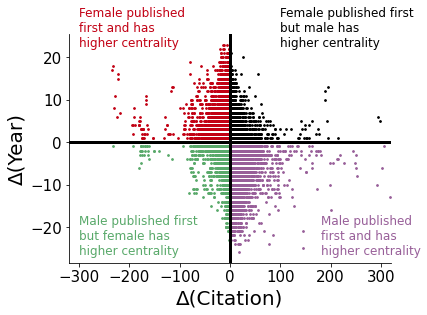

In [ ]:
# build scatterplots

# zeros are included for the graphic reasons - removed for analysis

# block12 = homp[homp['yeard'] >= 0]
# block34 = homp[homp['yeard'] < 0]

# block1 = block12[block12['countd'] >= 0]
# block2 = block12[block12['countd'] < 0]
# block4 = block34[block34['countd'] >= 0]
# block3 = block34[block34['countd'] < 0]

fig, ax = plt.subplots(figsize=(6,4.5))
right_side = ax.spines["right"]
top_side = ax.spines["top"]
right_side.set_visible(False)
top_side.set_visible(False)

# plt.title("PACS 00, Centrality and Year Difference")
plt.scatter(block1.countd, block1.yeard, s=3, c='#000000')
plt.scatter(block2.countd, block2.yeard, s=3, c='#c20114')
plt.scatter(block3.countd, block3.yeard, s=3, c='#59a96a')
plt.scatter(block4.countd, block4.yeard, s=3, c='#985f99')
plt.axhline(y=0, linewidth=0.5, c='k', lw=3)
plt.axvline(x=0, linewidth=0.5, c='k', lw=3)
plt.xlabel("\u0394(Citation)", fontsize=20)
plt.ylabel("\u0394(Year)", fontsize=20)
plt.xlim(xmin=-320, xmax=320)
# plt.xlim(xmin=-100)

t1 = ("Female published first \nbut male has \nhigher centrality")
t2 = ("Female published \nfirst and has \nhigher centrality")
t3 = ("Male published first \nbut female has \nhigher centrality")
t4 = ("Male published \nfirst and has \nhigher centrality")
plt.text(100, 23, t1, ha='left', rotation=0, wrap=True,fontsize=12, color='#000000')
plt.text(-300, 23, t2, ha='left', rotation=0, wrap=True,fontsize=12, color='#c20114')
plt.text(-300, -26, t3, ha='left', rotation=0, wrap=True,fontsize=12, color='#59a96a')
plt.text(180, -26, t4, ha='left', rotation=0, wrap=True,fontsize=12, color='#985f99')

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.tight_layout()
fig.savefig("drive/My Drive/codes/scatter.pdf")

# 1b. Centrality Difference Trend by Year

In [ ]:
############## SELECT DESIRED PACS (HOMOPHILY ONLY) ###############

homn = pd.read_csv("drive/My Drive/codes/hom0.csv")
# homn = pd.read_csv("drive/My Drive/codes/hom1.csv")
# homn = pd.read_csv("drive/My Drive/codes/hom2.csv")
# homn = pd.read_csv("drive/My Drive/codes/hom3.csv")
# homn = pd.read_csv("drive/My Drive/codes/hom4.csv")
# homn = pd.read_csv("drive/My Drive/codes/hom5.csv")
# homn = pd.read_csv("drive/My Drive/codes/hom6.csv")
# homn = pd.read_csv("drive/My Drive/codes/hom7.csv")
# homn = pd.read_csv("drive/My Drive/codes/hom8.csv")
# homn = pd.read_csv("drive/My Drive/codes/hom9.csv")

print(len(homn))
homn.head()

1189255


,paper1,gender1,year1,paper2,gender2,year2,qval,k
0,10.1103/PhysRevA.30.336,male,1984,10.1103/PhysRevA.34.1617,male,1986,0.001230,False
1,10.1103/PhysRevA.30.336,male,1984,10.1103/PhysRevA.34.4472,female,1986,0.017857,False
2,10.1103/PhysRevA.30.336,male,1984,10.1103/PhysRevA.41.784,male,1990,0.017857,False
3,10.1103/PhysRevA.34.4472,female,1986,10.1103/PhysRevA.41.784,male,1990,0.017857,False
4,10.1103/PhysRevA.36.4950,female,1987,10.1103/PhysRevA.41.784,male,1990,0.006410,False


In [ ]:
dc = data[["doi", "year"]].drop_duplicates(subset = 'doi')
dc = dc.merge(cb, left_on = 'doi',
              right_on = 'citing_doi', how = 'inner').drop(
                  ['doi'], axis=1).rename({'year': 'citing_year'}, axis=1)

cols = ['citing_doi', 'citing_year', 'cited_doi']
dc = dc.reindex(columns=cols).sort_values('cited_doi')

hom_mf = homn[homn["gender1"] != homn["gender2"]].reset_index(drop=True)

test = hom_mf.merge(dc, left_on = 'paper1',
                    right_on = 'cited_doi', how = 'left').drop(
                        ["cited_doi", "citing_year"], axis=1).drop_duplicates(
                            subset=['paper1', 'citing_doi'])
test['count'] = test.groupby(['paper1'])['paper1'].transform('count')
test = test.drop(["citing_doi"], axis=1).rename({'count': 'count1'}, axis=1)

test = test.drop_duplicates(subset=['paper1', 'paper2']).drop(
    ['gender1', 'year1', 'paper2', 'gender2', 'year2', 'qval', 'k'], axis=1)
hom_mf = hom_mf.merge(test, on='paper1', how='inner')

test = hom_mf.merge(dc, left_on = 'paper2',
                    right_on = 'cited_doi', how = 'left').drop(
                        ["cited_doi", "citing_year"], axis=1).drop_duplicates(
                            subset=['paper2', 'citing_doi'])
test['count'] = test.groupby(['paper2'])['paper2'].transform('count')
test = test.drop(["citing_doi"], axis=1).rename(
    {'count': 'count2'}, axis=1).drop_duplicates(
        subset=['paper1', 'paper2']).drop(
            ['gender1', 'year1', 'paper1', 'gender2', 'count1',
             'year2', 'qval', 'k'], axis=1)
hom_mf = hom_mf.merge(test, on='paper2', how='inner')

del test

listd = []
listy = []

for c in range(len(hom_mf)):
  if hom_mf['gender1'][c] == 'male':
    listd.append(hom_mf['count1'][c] - hom_mf['count2'][c])
    listy.append(hom_mf['year1'][c] - hom_mf['year2'][c])
  else:
    listd.append(hom_mf['count2'][c] - hom_mf['count1'][c])
    listy.append(hom_mf['year2'][c] - hom_mf['year1'][c])

hom_mf['countd'] = listd
hom_mf['yeard'] = listy

print(len(hom_mf))
hom_mf.head()

184694


,paper1,gender1,year1,paper2,gender2,year2,qval,k,count1,count2,countd,yeard
0,10.1103/PhysRevA.30.336,male,1984,10.1103/PhysRevA.34.4472,female,1986,0.017857,False,11,2,9,-2
1,10.1103/PhysRevA.34.4472,female,1986,10.1103/PhysRevA.41.784,male,1990,0.017857,False,2,8,6,4
2,10.1103/PhysRevA.36.4950,female,1987,10.1103/PhysRevA.41.784,male,1990,0.006410,False,1,8,7,3
3,10.1103/PhysRevA.39.5466,female,1989,10.1103/PhysRevA.41.784,male,1990,0.006410,False,4,8,4,1
4,10.1103/PhysRevA.41.3081,female,1990,10.1103/PhysRevA.41.784,male,1990,0.000511,False,1,8,7,0


In [ ]:
# use p-values from the paper
p = 0.002

homp = hom_mf[hom_mf['qval'] < p].sort_values('countd').reset_index(drop=True)

In [ ]:
plot_hom = homp[['year2', 'countd']].sort_values(by=['year2', 'countd'])
plot_hom['normalized'] = plot_hom['countd'].div(plot_hom['countd'].abs().groupby(
    plot_hom['year2']).transform('max'))
# plot_hom['gender'] = ['male' if x >=0 else 'female' for x in plot_hom['countd']]

print(len(plot_hom))
plot_hom.head()

9931


,year2,countd,normalized
1384,1982,-6,-0.105263
8610,1982,8,0.140351
9012,1982,11,0.192982
9861,1982,57,1.000000
9862,1982,57,1.000000


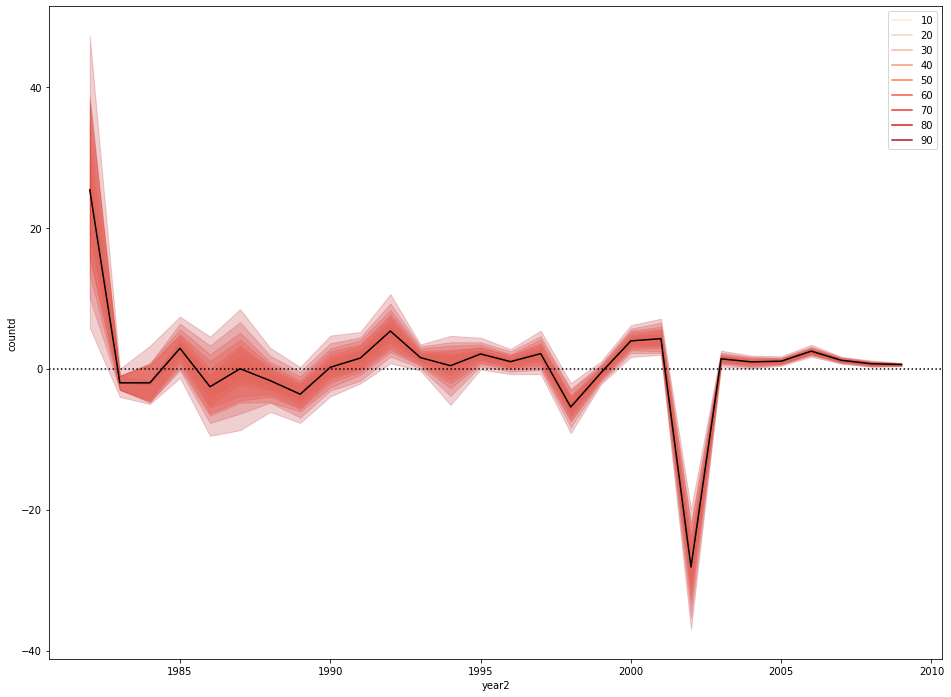

In [ ]:
fig,ax = plt.subplots(1,1, figsize=[16,12])

plt.axhline(y=0, color='black', linestyle='dotted')
sns.lineplot(data=plot_hom, x="year2", y="countd",ax=ax,ci=None,color="black")

cm = sns.color_palette("Reds",10)

for ix,ci in enumerate(range(10,100,10)):
    sns.lineplot(data=plot_hom, x="year2", y="countd",
                 ci = ci,
                 ax=ax,linestyle='',
                 hue = ci,palette={ci:cm[ix]})

In [ ]:
plot_hom2 = plot_hom.groupby(['year2', 'countd']).sum().reset_index().groupby('year2').mean()

fig,ax = plt.subplots(1,1, figsize=[16,12])

plt.axhline(y=0, color='black', linestyle='dotted')
sns.lineplot(data=plot_hom2, x="year2", y="countd",ax=ax,ci=None,color="black")

cm = sns.color_palette("Reds",10)

for ix,ci in enumerate(range(10,100,10)):
    sns.lineplot(data=plot_hom2, x="year2", y="countd",
                 ci = ci,
                 ax=ax,linestyle='',
                 hue = ci,palette={ci:cm[ix]})

In [ ]:
# violinplot

fig, axes = plt.subplots(figsize=[16,12])

axes.violinplot(dataset = [plot_hom[plot_hom.year2 < 1991]["countd"].values,
                           plot_hom[(plot_hom.year2 > 1990) & (plot_hom.year2 < 1996)]["countd"].values,
                           plot_hom[(plot_hom.year2 > 1995) & (plot_hom.year2 < 2001)]["countd"].values,
                           plot_hom[(plot_hom.year2 > 2000) & (plot_hom.year2 < 2006)]["countd"].values,
                           plot_hom[plot_hom.year2 > 2005]["countd"].values])

xnames = ["", "-1990", "1991-1995", "1996-2000", "2001-2005", "2005-2009"]

# axes.set_title('PACS 00, Centrality Difference by Year')
axes.set_xticklabels(xnames)
axes.yaxis.grid(True)
axes.set_xlabel('Year')
axes.set_ylabel('Centrality Difference')

plt.show()

In [ ]:
# normalized violinplot

fig, axes = plt.subplots(figsize=[16,12])

axes.violinplot(dataset = [plot_hom[plot_hom.year2 < 1991]["normalized"].values,
                           plot_hom[(plot_hom.year2 > 1990) & (plot_hom.year2 < 1996)]["normalized"].values,
                           plot_hom[(plot_hom.year2 > 1995) & (plot_hom.year2 < 2001)]["normalized"].values,
                           plot_hom[(plot_hom.year2 > 2000) & (plot_hom.year2 < 2006)]["normalized"].values,
                           plot_hom[plot_hom.year2 > 2005]["normalized"].values])

xnames = ["", "-1990", "1991-1995", "1996-2000", "2001-2005", "2005-2009"]

# axes.set_title('PACS 00, Normalized Centrality Difference by Year')
axes.set_xticklabels(xnames)
axes.yaxis.grid(True)
axes.set_xlabel('Year')
axes.set_ylabel('Normalized Centrality Difference')

plt.show()

In [ ]:
# A scatterplot with jitter
fig, ax = plt.subplots(figsize=(13,10))
sns.stripplot(data =plot_hom, x="year2", y="countd", ax=ax, jitter=0.2, size=5)
# plt.title('PACS 00, Centrality Difference by Year')
plt.xlabel('Year')
plt.ylabel('Centrality Difference')
plt.show()

In [ ]:
# A normalized scatterplot with jitter
fig, ax = plt.subplots(figsize=(13,10))
sns.stripplot(data =plot_hom, x="year2", y="normalized", ax=ax, jitter=0.2, size=5)
# plt.title('PACS 00, Centrality Difference by Year')
plt.xlabel('Year')
plt.ylabel('Normalized Centrality Difference')
plt.show()

In [ ]:
plot_hom = plot_hom.groupby(['year2','countd']).size().reset_index(name='count')
plot_hom.head()

# scatterplot

ax1 = plot_hom.plot.scatter(x="year2", y="countd", c='red', s="count",
                            figsize=(11,8), grid=True)
# ax1.set_title("PACS 00, Centrality Difference by Year")
ax1.set_xlabel("Year")
ax1.set_ylabel("Centrality Difference")

In [ ]:
# normalized scatterplot

# ax2 = plot_hom.plot.scatter(x="year2", y="normalized", c='darkblue', s="count",
#                             figsize=(11,8), grid=True)
# ax2.set_title("PACS 00, Centrality Difference by Year")
# ax2.set_xlabel("Year")
# ax2.set_ylabel("Normalized Centrality Difference")

#1c. Centrality Difference Trend by Year (NO PACS)

In [ ]:
pair = pd.read_csv("drive/My Drive/codes/pairdata.csv")
print(len(pair))
pair.head()

5856207


,paper1,gender1,year1,paper2,gender2,year2,qval,k
0,10.1103/PhysRevA.30.336,male,1984,10.1103/PhysRevA.34.1617,male,1986,0.001230,False
1,10.1103/PhysRevA.30.336,male,1984,10.1103/PhysRevA.34.4472,female,1986,0.017857,False
2,10.1103/PhysRevA.30.336,male,1984,10.1103/PhysRevA.41.784,male,1990,0.017857,False
3,10.1103/PhysRevA.34.4472,female,1986,10.1103/PhysRevA.41.784,male,1990,0.017857,False
4,10.1103/PhysRevA.36.4950,female,1987,10.1103/PhysRevA.41.784,male,1990,0.006410,False


In [ ]:
dc = data[["doi", "year"]].drop_duplicates(subset = 'doi')
dc = dc.merge(cb, left_on = 'doi',
              right_on = 'citing_doi', how = 'inner').drop(
                  ['doi'], axis=1).rename({'year': 'citing_year'}, axis=1)

cols = ['citing_doi', 'citing_year', 'cited_doi']
dc = dc.reindex(columns=cols).sort_values('cited_doi')

hom_mf = pair[pair["gender1"] != pair["gender2"]].reset_index(drop=True)

test = hom_mf.merge(dc, left_on = 'paper1',
                    right_on = 'cited_doi', how = 'left').drop(
                        ["cited_doi", "citing_year"], axis=1).drop_duplicates(
                            subset=['paper1', 'citing_doi'])
test['count'] = test.groupby(['paper1'])['paper1'].transform('count')
test = test.drop(["citing_doi"], axis=1).rename({'count': 'count1'}, axis=1)

test = test.drop_duplicates(subset=['paper1', 'paper2']).drop(
    ['gender1', 'year1', 'paper2', 'gender2', 'year2', 'qval', 'k'], axis=1)
hom_mf = hom_mf.merge(test, on='paper1', how='inner')

test = hom_mf.merge(dc, left_on = 'paper2',
                    right_on = 'cited_doi', how = 'left').drop(
                        ["cited_doi", "citing_year"], axis=1).drop_duplicates(
                            subset=['paper2', 'citing_doi'])
test['count'] = test.groupby(['paper2'])['paper2'].transform('count')
test = test.drop(["citing_doi"], axis=1).rename(
    {'count': 'count2'}, axis=1).drop_duplicates(
        subset=['paper1', 'paper2']).drop(
            ['gender1', 'year1', 'paper1', 'gender2', 'count1',
             'year2', 'qval', 'k'], axis=1)
hom_mf = hom_mf.merge(test, on='paper2', how='inner')

del test

listc = []

for j in range(len(hom_mf)):
  listc.append(max(hom_mf['year1'][j], hom_mf['year2'][j]))

hom_mf['year'] = listc

listd = []
listy = []

for c in range(len(hom_mf)):
  if hom_mf['gender1'][c] == 'male':
    listd.append(hom_mf['count1'][c] - hom_mf['count2'][c])
    listy.append(hom_mf['year1'][c] - hom_mf['year2'][c])
  else:
    listd.append(hom_mf['count2'][c] - hom_mf['count1'][c])
    listy.append(hom_mf['year2'][c] - hom_mf['year1'][c])

hom_mf['countd'] = listd
hom_mf['yeard'] = listy

print(len(hom_mf))
hom_mf.head()

991845


,paper1,gender1,year1,paper2,gender2,year2,qval,k,count1,count2,year,countd,yeard
0,10.1103/PhysRevA.30.336,male,1984,10.1103/PhysRevA.34.4472,female,1986,0.017857,False,11,2,1986,9,-2
1,10.1103/PhysRevA.30.336,male,1984,10.1103/PhysRevA.34.4472,female,1986,0.047619,False,11,2,1986,9,-2
2,10.1103/PhysRevLett.50.109,male,1983,10.1103/PhysRevA.34.4472,female,1986,0.017857,False,21,2,1986,19,-3
3,10.1103/PhysRevLett.50.109,male,1983,10.1103/PhysRevA.34.4472,female,1986,0.047619,False,21,2,1986,19,-3
4,10.1103/PhysRevLett.50.713,male,1983,10.1103/PhysRevA.34.4472,female,1986,0.035714,False,4,2,1986,2,-3


In [ ]:
hom_mf2 = hom_mf[hom_mf['yeard'] > -4].sort_values('yeard').reset_index(drop=True)
hom_mf2 = hom_mf2[hom_mf2['yeard'] < 4].sort_values('yeard').reset_index(drop=True)

In [ ]:
# use p-values from the paper
p = 0.002

homp = hom_mf2[hom_mf2['qval'] < p].sort_values('countd').reset_index(drop=True)
print(len(homp)/len(hom_mf2))
#homp.head()

0.06485455326102513


In [ ]:
plot_hom = homp[['year', 'countd']].sort_values(by=['year', 'countd'])
# plot_hom['normalized'] = plot_hom['countd'].div(plot_hom['countd'].abs().groupby(
#     plot_hom['year']).transform('max'))
# plot_hom['gender'] = ['male' if x >=0 else 'female' for x in plot_hom['countd']]

print(len(plot_hom))
plot_hom.head()

35799


,year,countd
19824,1983,0
20900,1983,1
20901,1983,1
30561,1983,7
14894,1984,0


In [ ]:
freqmf = plot_hom.groupby(['year'])['year'].count()

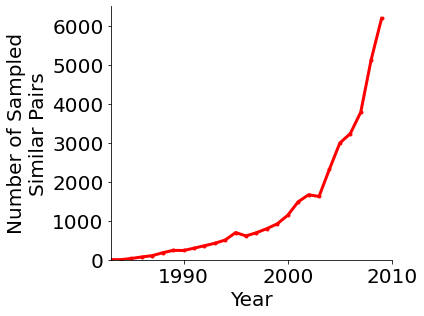

In [ ]:
fig, ax = plt.subplots(figsize=(6,4.5))
right_side = ax.spines["right"]
top_side = ax.spines["top"]
right_side.set_visible(False)
top_side.set_visible(False)

freqmf.plot(style='.-',color='red', lw=3)

plt.xlabel('Year', fontsize=20)
plt.xlim(xmin=1983, xmax=2010)
plt.xticks(np.arange(1990, 2011, 10), fontsize=20)
plt.ylabel('Number of Sampled\nSimilar Pairs', fontsize=20)
plt.yticks(fontsize=20)
plt.ylim(ymin=0)

plt.tight_layout()
# fig.savefig(f"drive/My Drive/codes/simcount.pdf")

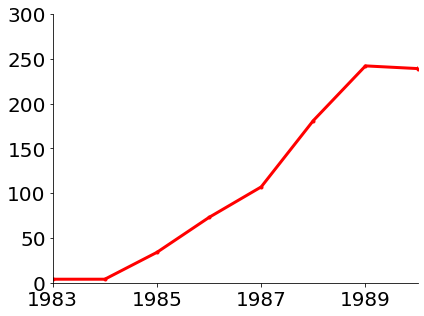

In [ ]:
fig, ax = plt.subplots(figsize=(6,4.5))
right_side = ax.spines["right"]
top_side = ax.spines["top"]
right_side.set_visible(False)
top_side.set_visible(False)

freqmf.plot(style='.-',color='red', lw=3)

# plt.xlabel('Year', fontsize=20)
plt.xlabel('')
plt.xlim(xmin=1983, xmax=1990)
plt.xticks(np.arange(1983, 1991, 2), fontsize=20)
# plt.ylabel('Number of Sampled\nSimilar Pairs', fontsize=20)
plt.yticks(fontsize=20)
plt.ylim(ymin=0, ymax=300)

plt.tight_layout()
fig.savefig(f"drive/My Drive/codes/zoomedsimcount.pdf")

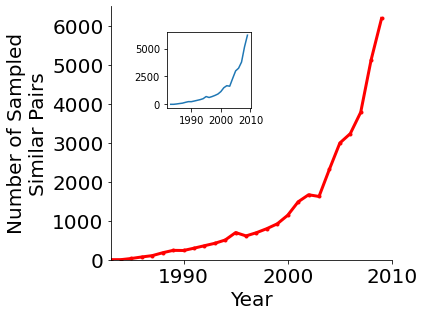

In [ ]:
fig, ax = plt.subplots(figsize=(6,4.5))
right_side = ax.spines["right"]
top_side = ax.spines["top"]
right_side.set_visible(False)
top_side.set_visible(False)

freqmf.plot(style='.-',color='red', lw=3)

inset_ax = ax.inset_axes([0.2, 0.6, 0.3, 0.3])
inset_ax.plot(freqmf)

plt.xlabel('Year', fontsize=20)
plt.xlim(xmin=1983, xmax=2010)
plt.xticks(np.arange(1990, 2011, 10), fontsize=20)
plt.ylabel('Number of Sampled\nSimilar Pairs', fontsize=20)
plt.yticks(fontsize=20)
plt.ylim(ymin=0)

plt.tight_layout()
# fig.savefig(f"drive/My Drive/codes/simcount.pdf")

In [ ]:
freqmf = plot_hom.groupby(['year'])['year'].count()
freqmf = pd.DataFrame({'year':freqmf.index, 'count':freqmf.values})

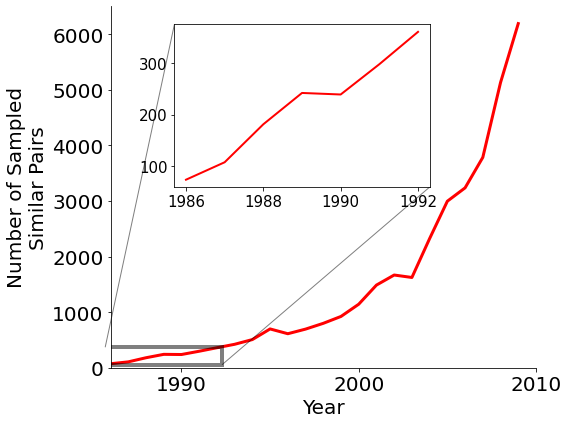

In [ ]:
fig, ax = plt.subplots(figsize=(8,6))
right_side = ax.spines["right"]
top_side = ax.spines["top"]
right_side.set_visible(False)
top_side.set_visible(False)

plt.plot(freqmf['year'], freqmf['count'], color='red', lw=3)

inset_ax = ax.inset_axes([0.15, 0.5, 0.6, 0.45])
inset_ax.plot(freqmf['year'][3:10], freqmf['count'][3:10], color='red', lw=2)
inset_ax.tick_params(labelsize=15)

plt.xlabel('Year', fontsize=20)
plt.xlim(xmin=1986, xmax=2010)
plt.xticks(np.arange(1990, 2011, 10), fontsize=20)
plt.ylabel('Number of Sampled\nSimilar Pairs', fontsize=20)
plt.yticks(fontsize=20)
plt.ylim(ymin=0)
ax.indicate_inset_zoom(inset_ax, edgecolor="black", linewidth = 4)

plt.tight_layout()
fig.savefig(f"drive/My Drive/codes/simcount_edit.pdf")

(array([-25.,   0.,  25.,  50.,  75., 100., 125., 150., 175., 200.]),
 <a list of 10 Text major ticklabel objects>)

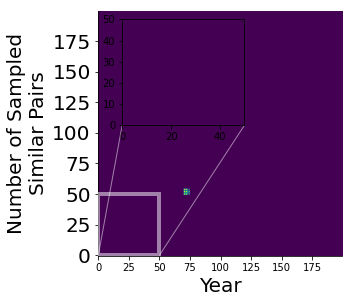

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

small = np.array([
    [1.0, 0.5, 1.0, 0.1, 0.3], 
    [0.5, 0.5, 0.5, 0.2, 0.4], 
    [1.0, 0.5, 1.0, 0.3, 0.6],
    [0.5, 0.5, 0.5, 0.2, 0.4],
    [1.0, 0.5, 1.0, 0.1, 0.3]
    ])

big = np.zeros((200, 200))

ny, nx = small.shape
big[50:50+ny, 70:70+nx] = small

# 도화지
fig, ax = plt.subplots(figsize=(6,4.5))
right_side = ax.spines["right"]
top_side = ax.spines["top"]
right_side.set_visible(False)
top_side.set_visible(False)

# 대형 그림 그리기, lower 를 넣으면 위아래가 뒤바뀜
ax.imshow(big, origin="lower")

# 작은 도화지, 큰 도화지의 0.5, 0.5 의 위치에서부터 0.4, 0.4 만큼의 크기의 도화지를 만듦
axins = ax.inset_axes([0.1, 0.5, 0.5, 0.5])

# 작은 도화지에 큰 그림을 그림
axins.imshow(big, origin="lower")

# xlim, ylim 을 조정하여 무늬가 속하도록 만듦
x1, x2, y1, y2 = 0, 50, 0, 50
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)

# 줌인 느낌의 그림
ax.indicate_inset_zoom(axins, edgecolor="w", linewidth = 4)

plt.xlabel('Year', fontsize=20)
# plt.xlim(xmin=1983, xmax=2010)
# plt.xticks(np.arange(1990, 2011, 10), fontsize=20)
plt.ylabel('Number of Sampled\nSimilar Pairs', fontsize=20)
plt.yticks(fontsize=20)
# plt.ylim(ymin=0)

Text(0, 0.5, 'Δ(Citation)')

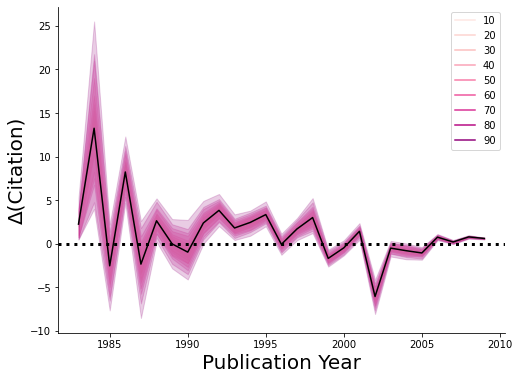

In [ ]:
# fig,ax = plt.subplots(1,1, figsize=[12,9])

fig, ax = plt.subplots(figsize=(8,6))
right_side = ax.spines["right"]
top_side = ax.spines["top"]
right_side.set_visible(False)
top_side.set_visible(False)

plt.axhline(y=0, color='black', linestyle='dotted', lw=3)
sns.lineplot(data=plot_hom, x="year", y="countd",ax=ax,ci=None,color="black")

cm = sns.color_palette("RdPu",10)

for ix,ci in enumerate(range(10,100,10)):
    sns.lineplot(data=plot_hom, x="year", y="countd",
                 ci = ci,
                 ax=ax,linestyle='',
                 hue = ci,palette={ci:cm[ix]})

# plt.title("Percentile Plot of Degree Centrality Difference between Similar Pairs")
plt.xlabel("Publication Year", fontsize=20)
plt.ylabel("\u0394(Citation)", fontsize=20)

In [ ]:
mwu1 = plot_hom[plot_hom['year'] <= 1995]
mwu2 = plot_hom[plot_hom['year'] > 1995]

scipy.stats.mannwhitneyu(mwu1.countd, mwu2.countd)

MannwhitneyuResult(statistic=48621131.5, pvalue=6.886259244347325e-09)

In [ ]:
for i in range(10):
  fig, ax = plt.subplots()
  right_side = ax.spines["right"]
  top_side = ax.spines["top"]
  right_side.set_visible(False)
  top_side.set_visible(False)

  plt.axhline(y=0, color='black', linestyle='dotted', lw=3)

  subplot_hom = plot_hom[plot_hom["year"] <= 1995].sample(50)
  sns.lineplot(data=subplot_hom, x="year", y="countd",ax=ax,ci=None,color='red')

  plt.xlabel("Publication Year")
  plt.ylabel("\u0394(Citation)")
  fig.savefig(f"drive/My Drive/codes/mfpair_plot{i}.png")

### 1c'. Graphs (non-use)

In [ ]:
hue = []
for i in range(len(plot_hom)):
  plot_hom = plot_hom.sort_index()
  if plot_hom['year'][i] <= 1995:
    hue.append('-1995')
  else:
    hue.append('1996-')

plot_hom['time period'] = hue
plot_hom.head()

plt.figure(1)
plot_hom.boxplot(column = 'countd', by = 'time period', figsize=[12,9]) # w/o outliers

plt.title("\u0394(Citation) Distribution of Similar Pairs")
plt.xlabel("Publication Year")
plt.ylabel("\u0394(Citation)")
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

plt.figure(2)
plot_hom.boxplot(column = 'countd', by = 'time period', showfliers=False, figsize=[12,9]) # w/o outliers

plt.title("\u0394(Citation) Distribution of Similar Pairs")
plt.xlabel("Publication Year")
plt.ylabel("\u0394(Citation)")
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

plt.show()

In [ ]:
# fig,ax = plt.subplots(1,1, figsize=[12,9])

# plt.axhline(y=0, color='black', linestyle='dotted')
# sns.lineplot(data=plot_hom, x="year", y="normalized",ax=ax,ci=None,color="black")

# cm = sns.color_palette("YlOrBr",10)

# for ix,ci in enumerate(range(10,100,10)):
#     sns.lineplot(data=plot_hom, x="year", y="normalized",
#                  ci = ci,
#                  ax=ax,linestyle='',
#                  hue = ci,palette={ci:cm[ix]})

# plt.title("Percentile Plot of Degree Centrality Difference between Similar Pairs")
# plt.xlabel("Publication Year")
# plt.ylabel("Normalized Centrality Difference")

In [ ]:
plot_woo = plot_hom[plot_hom['countd'] < 500]
plot_woo = plot_woo[plot_woo['countd'] > -500]

fig,ax = plt.subplots(1,1, figsize=[12,9])

plt.axhline(y=0, color='black', linestyle='dotted')
sns.lineplot(data=plot_woo, x="year", y="countd",ax=ax,ci=None,color="black")

cm = sns.color_palette("Blues",10)

for ix,ci in enumerate(range(10,100,10)):
    sns.lineplot(data=plot_woo, x="year", y="countd",
                 ci = ci,
                 ax=ax,linestyle='',
                 hue = ci,palette={ci:cm[ix]})

plt.title("Percentile Plot of Degree Centrality Difference between Similar Pairs (without high centrality papers)")
plt.xlabel("Publication Year")
plt.ylabel("\u0394(Citation)")

# 1c-2. Male-male comparision setup

In [ ]:
pair = pd.read_csv("drive/My Drive/codes/pairdata.csv")
print(len(pair))
pair.head()

5856207


,paper1,gender1,year1,paper2,gender2,year2,qval,k
0,10.1103/PhysRevA.30.336,male,1984,10.1103/PhysRevA.34.1617,male,1986,0.001230,False
1,10.1103/PhysRevA.30.336,male,1984,10.1103/PhysRevA.34.4472,female,1986,0.017857,False
2,10.1103/PhysRevA.30.336,male,1984,10.1103/PhysRevA.41.784,male,1990,0.017857,False
3,10.1103/PhysRevA.34.4472,female,1986,10.1103/PhysRevA.41.784,male,1990,0.017857,False
4,10.1103/PhysRevA.36.4950,female,1987,10.1103/PhysRevA.41.784,male,1990,0.006410,False


In [ ]:
dc = data[["doi", "year"]].drop_duplicates(subset = 'doi')
dc = dc.merge(cb, left_on = 'doi',
              right_on = 'citing_doi', how = 'inner').drop(
                  ['doi'], axis=1).rename({'year': 'citing_year'}, axis=1)

cols = ['citing_doi', 'citing_year', 'cited_doi']
dc = dc.reindex(columns=cols).sort_values('cited_doi')

hom_mm = pair[pair["gender1"] == "male"].reset_index(drop=True)
hom_mm = hom_mm[hom_mm["gender2"] == "male"].reset_index(drop=True)

hom_mm.to_csv("drive/My Drive/codes/hom_mm_1.csv", index=False)
dc.to_csv("drive/My Drive/codes/dc_1.csv", index=False)

In [ ]:
hom_mm = pd.read_csv("drive/My Drive/codes/hom_mm_1.csv")
dc = pd.read_csv("drive/My Drive/codes/dc_1.csv")

test = hom_mm.merge(dc, left_on = 'paper1',
                    right_on = 'cited_doi', how = 'left').drop(
                        ["cited_doi", "citing_year"], axis=1).drop_duplicates(
                            subset=['paper1', 'citing_doi'])
test['count'] = test.groupby(['paper1'])['paper1'].transform('count')
test = test.drop(["citing_doi"], axis=1).rename({'count': 'count1'}, axis=1)

In [ ]:
test.to_csv("drive/My Drive/codes/test_1.csv", index=False)

In [ ]:
test = pd.read_csv("drive/My Drive/codes/test_1.csv")
hom_mm = pd.read_csv("drive/My Drive/codes/hom_mm_1.csv")

test = test.drop_duplicates(subset=['paper1', 'paper2']).drop(
    ['gender1', 'year1', 'paper2', 'gender2', 'year2', 'qval', 'k'], axis=1)
hom_mm = hom_mm.merge(test, on='paper1', how='inner')

hom_mm.to_csv("drive/My Drive/codes/hom_mm_1.csv", index=False)

In [ ]:
hom_mm = pd.read_csv("drive/My Drive/codes/hom_mm_1.csv")
dc = pd.read_csv("drive/My Drive/codes/dc_1.csv")

print(len(hom_mm))
print(len(dc))

4797249
2815130


In [ ]:
hom_mm = hom_mm[:len(hom_mm)//2]
test = hom_mm.merge(dc, left_on = 'paper2',
                    right_on = 'cited_doi', how = 'left').drop(
                        ["cited_doi", "citing_year"], axis=1).drop_duplicates(
                            subset=['paper2', 'citing_doi'])
test.to_csv("drive/My Drive/codes/test_1.csv", index=False)

In [ ]:
hom_mm = pd.read_csv("drive/My Drive/codes/hom_mm_1.csv")
hom_mm = hom_mm[len(hom_mm)//2:]
test = hom_mm.merge(dc, left_on = 'paper2',
                    right_on = 'cited_doi', how = 'left').drop(
                        ["cited_doi", "citing_year"], axis=1).drop_duplicates(
                            subset=['paper2', 'citing_doi'])
test.to_csv("drive/My Drive/codes/test_2.csv", index=False)

In [ ]:
test1 = pd.read_csv("drive/My Drive/codes/test_1.csv")
test2 = pd.read_csv("drive/My Drive/codes/test_2.csv")
test = pd.concat([test1, test2])
test['count'] = test.groupby(['paper2'])['paper2'].transform('count')
# test.head(50)
test.to_csv("drive/My Drive/codes/test.csv", index=False)

In [ ]:
hom_mm = pd.read_csv("drive/My Drive/codes/hom_mm_1.csv")
test = pd.read_csv("drive/My Drive/codes/test.csv")

test = test.drop_duplicates(subset=['paper2', 'citing_doi'])

test = test.drop(["citing_doi"], axis=1).rename(
    {'count': 'count2'}, axis=1).drop_duplicates(
        subset=['paper1', 'paper2']).drop(
            ['gender1', 'year1', 'paper1', 'gender2', 'count1',
             'year2', 'qval', 'k'], axis=1)
hom_mm = hom_mm.merge(test, on='paper2', how='inner')

In [ ]:
hom_mm = hom_mm.sort_values(['paper1', 'paper2', 'qval']).drop_duplicates(subset=['paper1', 'paper2'])
# hom_mm.head()

hom_mm.to_csv("drive/My Drive/codes/hom_mm.csv", index=False)

In [ ]:
hom_mm.head()

,paper1,gender1,year1,paper2,gender2,year2,qval,k,count1,count2
1816,10.1103/PhysRevA.30.336,male,1984,10.1103/PhysRevA.33.360,male,1986,0.004950,False,11,3
0,10.1103/PhysRevA.30.336,male,1984,10.1103/PhysRevA.34.1617,male,1986,0.001230,False,11,20
1817,10.1103/PhysRevA.30.336,male,1984,10.1103/PhysRevA.35.1740,male,1987,0.047619,False,11,3
1819,10.1103/PhysRevA.30.336,male,1984,10.1103/PhysRevA.35.4247,male,1987,0.095238,False,11,2
1825,10.1103/PhysRevA.30.336,male,1984,10.1103/PhysRevA.38.5193,male,1988,0.004950,False,11,7


This is the dataset I saved for hom_mm.

## 1c-2A. Male-male comparision (outdated)

In [ ]:
hom_mm = pd.read_csv("drive/My Drive/codes/hom_mm.csv")

listc = []

for j in range(len(hom_mm)):
  listc.append(max(hom_mm['year1'][j], hom_mm['year2'][j]))

hom_mm['year'] = listc

listd = []
listy = []

for c in range(len(hom_mm)):
  if hom_mm['gender1'][c] == 'male':
    listd.append(hom_mm['count1'][c] - hom_mm['count2'][c])
    listy.append(hom_mm['year1'][c] - hom_mm['year2'][c])
  else:
    listd.append(hom_mm['count2'][c] - hom_mm['count1'][c])
    listy.append(hom_mm['year2'][c] - hom_mm['year1'][c])

hom_mm['countd'] = listd
hom_mm['yeard'] = listy

print(len(hom_mm))
hom_mm.head()

In [ ]:
hom_mm2 = hom_mm[hom_mm['yeard'] > -4].sort_values('yeard').reset_index(drop=True)
hom_mm2 = hom_mm2[hom_mm2['yeard'] < 4].sort_values('yeard').reset_index(drop=True)

In [ ]:
# use p-values from the paper
p = 0.0015

homp2 = hom_mm2[hom_mm2['qval'] < p].sort_values('countd').reset_index(drop=True)
print(len(homp2)/len(hom_mm2))
homp2.head()

In [ ]:
plot_hom2 = homp2[['year', 'countd', 'yeard']].sort_values(by=['year', 'countd', 'yeard'])

print(len(plot_hom2))
plot_hom2.head()

144815


,year,countd,yeard
1022,1981,-109,0
14352,1981,-20,0
14364,1981,-20,0
23850,1981,-12,-1
49471,1981,-3,-1


In [ ]:
dflist = []
simul = 0

while simul < 100:

  subplot_hom2 = plot_hom2[plot_hom2["year"] <= 1995].sample(50) # THIS IS A PRE-1995 DATASET
  # subplot_hom2 = plot_hom2.sample(50) # THIS IS A WHOLE DATASET
  # print(subplot_hom2.head())
  for j in range(0, len(subplot_hom2), 2):
    if subplot_hom2['yeard'].iloc[j] <= 0:
      subplot_hom2['yeard'].iloc[j] *= -1
      subplot_hom2['countd'].iloc[j] *= -1
    if subplot_hom2['yeard'].iloc[j+1] >= 0:
      subplot_hom2['yeard'].iloc[j+1] *= -1
      subplot_hom2['countd'].iloc[j+1] *= -1

  dflist.append(subplot_hom2)
  simul += 1

df = pd.concat(dflist, axis=0, ignore_index=True)

In [ ]:
fig, ax = plt.subplots(figsize=(8,6))
right_side = ax.spines["right"]
top_side = ax.spines["top"]
right_side.set_visible(False)
top_side.set_visible(False)

plt.axhline(y=0, color='black', linestyle='dotted', lw=3)
sns.lineplot(data=df, x="year", y="countd",ax=ax,ci=None,color="black")

cm = sns.color_palette("Blues",10)

for ix,ci in enumerate(range(10,100,10)):
    sns.lineplot(data=df, x="year", y="countd",
                 ci = ci,
                 ax=ax,linestyle='',
                 hue = ci,palette={ci:cm[ix]})

# plt.title("Percentile Plot of Degree Centrality Difference between Similar Pairs")
plt.xlabel("Publication Year", fontsize=20)
plt.ylabel("\u0394(Citation)", fontsize=20)

In [ ]:
for i in range(10):

  dflist = []
  simul = 0

  while simul < 100:

    # subplot_hom2 = plot_hom2[plot_hom2["year"] <= 1995].sample(50) # THIS IS A PRE-1995 DATASET
    subplot_hom2 = plot_hom2.sample(50) # THIS IS A WHOLE DATASET
    # print(subplot_hom2.head())
    for j in range(0, len(subplot_hom2), 2):
      if subplot_hom2['yeard'].iloc[j] <= 0:
        subplot_hom2['yeard'].iloc[j] *= -1
        subplot_hom2['countd'].iloc[j] *= -1
      if subplot_hom2['yeard'].iloc[j+1] >= 0:
        subplot_hom2['yeard'].iloc[j+1] *= -1
        subplot_hom2['countd'].iloc[j+1] *= -1

    dflist.append(subplot_hom2)
    simul += 1

  df = pd.concat(dflist, axis=0, ignore_index=True)

  fig, ax = plt.subplots(figsize=(8,6))
  right_side = ax.spines["right"]
  top_side = ax.spines["top"]
  right_side.set_visible(False)
  top_side.set_visible(False)

  plt.axhline(y=0, color='black', linestyle='dotted', lw=3)
  sns.lineplot(data=plot_hom, x="year", y="countd",ax=ax,ci=None,color="red")
  sns.lineplot(data=df, x="year", y="countd",ax=ax,ci=None,color="blue")

  cm1 = sns.color_palette("Reds",10)

  for ix,ci in enumerate(range(10,100,10)):
      sns.lineplot(data=plot_hom, x="year", y="countd",
                  ci = ci,
                  ax=ax,linestyle='',
                  hue = ci,palette={ci:cm1[ix]},
                  legend = False)
      
  cm2 = sns.color_palette("Blues",10)
      
  for ix,ci in enumerate(range(10,100,10)):
      sns.lineplot(data=df, x="year", y="countd",
                  ci = ci,
                  ax=ax,linestyle='',
                  hue = ci,palette={ci:cm2[ix]},
                  legend = False)

  # plt.title("Percentile Plot of Degree Centrality Difference between Similar Pairs")
  plt.xlabel("Publication Year", fontsize=20)
  plt.xticks(np.arange(1980, 2010, 5),fontsize=20)
  # plt.xlim(xmax=1995)
  plt.yticks(fontsize=20)
  plt.ylabel("\u0394(Citation)", fontsize=20)

  fig.savefig(f"drive/My Drive/codes/fullcomparison_plot{i}.pdf")

# 1c-2B. REAL Comparison Analysis

In [ ]:
pair = pd.read_csv("drive/My Drive/codes/pairdata.csv")

dc = data[["doi", "year"]].drop_duplicates(subset = 'doi')
dc = dc.merge(cb, left_on = 'doi',
              right_on = 'citing_doi', how = 'inner').drop(
                  ['doi'], axis=1).rename({'year': 'citing_year'}, axis=1)

cols = ['citing_doi', 'citing_year', 'cited_doi']
dc = dc.reindex(columns=cols).sort_values('cited_doi')

hom_mf = pair[pair["gender1"] != pair["gender2"]].reset_index(drop=True)

test = hom_mf.merge(dc, left_on = 'paper1',
                    right_on = 'cited_doi', how = 'left').drop(
                        ["cited_doi", "citing_year"], axis=1).drop_duplicates(
                            subset=['paper1', 'citing_doi'])
test['count'] = test.groupby(['paper1'])['paper1'].transform('count')
test = test.drop(["citing_doi"], axis=1).rename({'count': 'count1'}, axis=1)

test = test.drop_duplicates(subset=['paper1', 'paper2']).drop(
    ['gender1', 'year1', 'paper2', 'gender2', 'year2', 'qval', 'k'], axis=1)
hom_mf = hom_mf.merge(test, on='paper1', how='inner')

test = hom_mf.merge(dc, left_on = 'paper2',
                    right_on = 'cited_doi', how = 'left').drop(
                        ["cited_doi", "citing_year"], axis=1).drop_duplicates(
                            subset=['paper2', 'citing_doi'])
test['count'] = test.groupby(['paper2'])['paper2'].transform('count')
test = test.drop(["citing_doi"], axis=1).rename(
    {'count': 'count2'}, axis=1).drop_duplicates(
        subset=['paper1', 'paper2']).drop(
            ['gender1', 'year1', 'paper1', 'gender2', 'count1',
             'year2', 'qval', 'k'], axis=1)
hom_mf = hom_mf.merge(test, on='paper2', how='inner')

del test

listc = []

for j in range(len(hom_mf)):
  listc.append(max(hom_mf['year1'][j], hom_mf['year2'][j]))

hom_mf['year'] = listc

listd = []
listy = []

for c in range(len(hom_mf)):
  if hom_mf['gender1'][c] == 'male':
    listd.append(hom_mf['count1'][c] - hom_mf['count2'][c])
    listy.append(hom_mf['year1'][c] - hom_mf['year2'][c])
  else:
    listd.append(hom_mf['count2'][c] - hom_mf['count1'][c])
    listy.append(hom_mf['year2'][c] - hom_mf['year1'][c])

hom_mf['countd'] = listd
hom_mf['yeard'] = listy

# print(len(hom_mf))
# hom_mf.head()

hom_mf2 = hom_mf[hom_mf['yeard'] > -4].sort_values('yeard').reset_index(drop=True)
hom_mf2 = hom_mf2[hom_mf2['yeard'] < 4].sort_values('yeard').reset_index(drop=True)

p = 0.002

homp = hom_mf2[hom_mf2['qval'] < p].sort_values('countd').reset_index(drop=True)
plot_hom = homp[['year', 'countd']].sort_values(by=['year', 'countd'])

print(len(homp)/len(hom_mf2))

0.06485455326102513


In [ ]:
hom_mm = pd.read_csv("drive/My Drive/codes/hom_mm.csv")

listc = []

for j in range(len(hom_mm)):
  listc.append(max(hom_mm['year1'][j], hom_mm['year2'][j]))

hom_mm['year'] = listc

listd = []
listy = []

for c in range(len(hom_mm)):
  if hom_mm['gender1'][c] == 'male':
    listd.append(hom_mm['count1'][c] - hom_mm['count2'][c])
    listy.append(hom_mm['year1'][c] - hom_mm['year2'][c])
  else:
    listd.append(hom_mm['count2'][c] - hom_mm['count1'][c])
    listy.append(hom_mm['year2'][c] - hom_mm['year1'][c])

hom_mm['countd'] = listd
hom_mm['yeard'] = listy

hom_mm2 = hom_mm[hom_mm['yeard'] > -4].sort_values('yeard').reset_index(drop=True)
hom_mm2 = hom_mm2[hom_mm2['yeard'] < 4].sort_values('yeard').reset_index(drop=True)

p = 0.001

homp2 = hom_mm2[hom_mm2['qval'] < p].sort_values('countd').reset_index(drop=True)

plot_hom2 = homp2[['year', 'countd']].sort_values(by=['year', 'countd'])

print(len(homp2)/len(hom_mm2))

0.04039170885109462


In [ ]:
def percentile(n):
    def percentile_(x):
        return np.percentile(x, n)
    percentile_.__name__ = 'percentile_%s' % n
    return percentile_

In [ ]:
mfpair = plot_hom.groupby('year').agg([np.mean, percentile(10), percentile(20), percentile(30), percentile(40), np.median, percentile(60), percentile(70), percentile(80), percentile(90)]).reset_index()

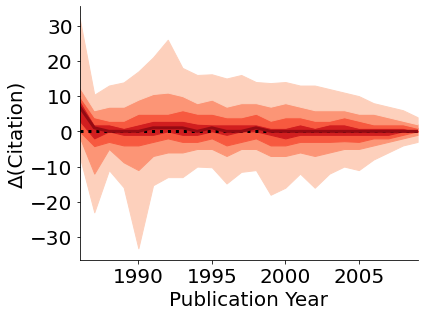

In [ ]:
fig, ax = plt.subplots(figsize=(6,4.5))
right_side = ax.spines["right"]
top_side = ax.spines["top"]
right_side.set_visible(False)
top_side.set_visible(False)

cm = sns.color_palette("Reds",10)

plt.axhline(y=0, color='black', linestyle='dotted', lw=3)
# sns.lineplot(data=mfpair, x="year", y='countd',ax=ax,ci=None,color="black")
plt.plot(mfpair.year,mfpair.countd["median"],"-",label="M-F Median", color=cm[9], lw=3)

plt.fill_between(mfpair.year, mfpair.countd["percentile_10"], mfpair.countd["percentile_20"], color=cm[1])
plt.fill_between(mfpair.year, mfpair.countd["percentile_20"], mfpair.countd["percentile_30"], color=cm[3])
plt.fill_between(mfpair.year, mfpair.countd["percentile_30"], mfpair.countd["percentile_40"], color=cm[5])
plt.fill_between(mfpair.year, mfpair.countd["percentile_40"], mfpair.countd["median"], color=cm[7])
plt.fill_between(mfpair.year, mfpair.countd["median"], mfpair.countd["percentile_60"], color=cm[7])
plt.fill_between(mfpair.year, mfpair.countd["percentile_60"], mfpair.countd["percentile_70"], color=cm[5])
plt.fill_between(mfpair.year, mfpair.countd["percentile_70"], mfpair.countd["percentile_80"], color=cm[3])
plt.fill_between(mfpair.year, mfpair.countd["percentile_80"], mfpair.countd["percentile_90"], color=cm[1])

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel("Publication Year", fontsize=20)
plt.ylabel("\u0394(Citation)", fontsize=20)

plt.xlim(xmin=1986, xmax=2009)

plt.tight_layout()
#fig.savefig(f"drive/My Drive/codes/mfpair_y10.pdf")

In [ ]:
ref = plot_hom.year.unique()

numlist = []

final_df = pd.DataFrame(columns=['year'])

for num in range(1983,2010):
  numlist.append(num)
final_df['year'] = numlist

In [ ]:
import warnings
warnings.filterwarnings("ignore")

for k in range(100):
  new_df = pd.DataFrame(columns=['year', 'countd'])
  vlist = []

  for i in range(len(ref)):
    appended_df = plot_hom2[plot_hom2['year'] == ref[i]].sample(plot_hom.year.value_counts().sort_index().iloc[i], replace=True)
    new_df = pd.concat([new_df,appended_df])
    
  for j in range(len(new_df)):
    if randint(0,1) == 0:
      vlist.append(new_df.countd.iloc[j])
    else:
      vlist.append(new_df.countd.iloc[j] * -1)
    
  new_df['value'] = vlist
  new_df = new_df.groupby("year").agg([np.mean]).reset_index().drop(['year'], axis=1)

  final_df = pd.concat([final_df, new_df], axis=1)

In [ ]:
final_df.head()

,year,"(value, mean)","(value, mean)","(value, mean)","(value, mean)","(value, mean)","(value, mean)","(value, mean)","(value, mean)","(value, mean)","(value, mean)","(value, mean)","(value, mean)","(value, mean)","(value, mean)","(value, mean)","(value, mean)","(value, mean)","(value, mean)","(value, mean)","(value, mean)","(value, mean)","(value, mean)","(value, mean)","(value, mean)","(value, mean)","(value, mean)","(value, mean)","(value, mean)","(value, mean)","(value, mean)","(value, mean)","(value, mean)","(value, mean)","(value, mean)","(value, mean)","(value, mean)","(value, mean)","(value, mean)","(value, mean)",...,"(value, mean)","(value, mean)","(value, mean)","(value, mean)","(value, mean)","(value, mean)","(value, mean)","(value, mean)","(value, mean)","(value, mean)","(value, mean)","(value, mean)","(value, mean)","(value, mean)","(value, mean)","(value, mean)","(value, mean)","(value, mean)","(value, mean)","(value, mean)","(value, mean)","(value, mean)","(value, mean)","(value, mean)","(value, mean)","(value, mean)","(value, mean)","(value, mean)","(value, mean)","(value, mean)","(value, mean)","(value, mean)","(value, mean)","(value, mean)","(value, mean)","(value, mean)","(value, mean)","(value, mean)","(value, mean)","(value, mean)"
0,1983,20.250000,-1.000000,23.750000,2.000000,-28.750000,25.000000,43.750000,3.500000,4.500000,-2.250000,-0.500000,-1.500000,-22.000000,2.000000,5.250000,6.000000,5.250000,20.000000,3.750000,-3.750000,-28.000000,-17.000000,23.750000,21.500000,-3.500000,-21.000000,-14.750000,-6.000000,-9.000000,32.000000,7.500000,1.750000,5.500000,-16.000000,-2.000000,0.250000,-23.250000,-44.000000,-42.000000,...,19.750000,0.750000,-21.000000,27.500000,2.000000,-16.000000,42.750000,11.000000,5.750000,3.250000,14.000000,18.250000,-10.500000,23.000000,21.000000,-19.750000,18.500000,1.250000,20.750000,21.750000,0.250000,-1.750000,-15.000000,3.000000,8.000000,21.250000,-20.000000,6.250000,-5.000000,7.250000,-15.750000,-3.500000,24.250000,17.000000,3.250000,20.250000,22.750000,8.000000,-22.250000,-1.500000
1,1984,27.000000,12.750000,-2.250000,6.750000,5.500000,-3.000000,-4.250000,3.750000,-6.750000,4.250000,-2.000000,0.000000,10.250000,2.500000,-4.750000,-11.000000,5.250000,-11.750000,3.250000,6.750000,6.750000,0.000000,-11.000000,0.000000,1.000000,22.750000,-9.500000,-9.750000,30.750000,-2.750000,-4.750000,0.500000,7.750000,-3.000000,4.500000,27.000000,-1.250000,1.500000,-30.500000,...,-1.000000,23.500000,13.000000,23.750000,-34.000000,1.750000,-27.750000,6.750000,-13.250000,-9.000000,2.000000,1.250000,3.000000,45.000000,16.000000,-12.250000,2.000000,1.250000,25.500000,-3.000000,1.500000,7.250000,30.250000,7.750000,-2.500000,-6.000000,6.500000,11.500000,-28.500000,-1.500000,-1.500000,6.250000,-36.250000,31.000000,-2.000000,2.000000,-14.500000,-26.500000,-35.000000,6.250000
2,1985,7.088235,1.058824,-0.029412,4.911765,10.205882,-0.235294,-4.441176,0.647059,0.852941,-7.000000,-4.117647,-5.441176,-0.294118,-3.264706,3.588235,5.117647,2.794118,-5.735294,-15.117647,8.500000,-9.617647,-2.264706,4.441176,1.058824,0.470588,1.029412,3.470588,-4.970588,-0.852941,-2.823529,-6.911765,-2.500000,5.029412,1.147059,-1.441176,6.882353,-2.970588,0.882353,8.235294,...,-7.588235,0.264706,-5.970588,-3.411765,3.411765,2.941176,1.558824,6.088235,-0.735294,3.500000,1.058824,4.705882,-4.147059,-3.970588,0.558824,11.176471,-2.323529,2.970588,-3.558824,-1.205882,0.352941,5.352941,-1.352941,9.970588,-3.852941,-8.470588,-0.852941,-2.970588,-1.029412,-1.676471,9.352941,0.558824,11.058824,2.852941,-1.323529,-1.676471,5.176471,-12.352941,-1.352941,0.352941
3,1986,13.863014,2.013699,-0.945205,-7.000000,36.849315,6.904110,3.616438,-12.780822,0.068493,9.630137,-1.958904,-8.808219,-9.958904,-9.575342,1.397260,-0.205479,17.684932,-4.972603,-26.123288,5.904110,12.356164,3.260274,11.547945,-0.356164,-0.561644,-2.123288,-8.739726,-0.986301,-16.095890,-13.054795,0.273973,15.273973,-3.000000,-2.808219,8.876712,-4.589041,-4.424658,-0.931507,-

In [ ]:
mmpair = final_df.copy()

list_1 = []
list_2 = []
list_3 = []
list_4 = []
mlist = []
list_6 = []
list_7 = []
list_8 = []
list_9 = []

for i in range(len(mmpair)):
  list_1.append(np.percentile(mmpair.iloc[i,1:],10))
  list_2.append(np.percentile(mmpair.iloc[i,1:],20))
  list_3.append(np.percentile(mmpair.iloc[i,1:],30))
  list_4.append(np.percentile(mmpair.iloc[i,1:],40))
  mlist.append(np.median(mmpair.iloc[i,1:]))
  list_6.append(np.percentile(mmpair.iloc[i,1:],60))
  list_7.append(np.percentile(mmpair.iloc[i,1:],70))
  list_8.append(np.percentile(mmpair.iloc[i,1:],80))
  list_9.append(np.percentile(mmpair.iloc[i,1:],90))

mmpair['percentile_10'] = list_1
mmpair['percentile_20'] = list_2
mmpair['percentile_30'] = list_3
mmpair['percentile_40'] = list_4
mmpair['median'] = mlist
mmpair['percentile_60'] = list_6
mmpair['percentile_70'] = list_7
mmpair['percentile_80'] = list_8
mmpair['percentile_90'] = list_9

mmpair = mmpair[['year', 'percentile_10','percentile_20','percentile_30','percentile_40','median','percentile_60','percentile_70','percentile_80','percentile_90']]
mmpair

,year,percentile_10,percentile_20,percentile_30,percentile_40,median,percentile_60,percentile_70,percentile_80,percentile_90
0,1983,-20.100000,-9.300000,-3.500000,0.250000,2.500000,5.350000,11.900000,20.800000,23.525000
1,1984,-11.800000,-7.400000,-3.000000,-1.500000,1.125000,2.100000,4.725000,6.850000,22.825000
2,1985,-5.891176,-4.000000,-2.376471,-1.217647,0.117647,0.941176,2.114706,4.494118,8.208824
3,1986,-12.373973,-7.358904,-3.050685,-1.871233,-0.458904,0.249315,2.715068,4.816438,10.832877
4,1987,-3.701869,-2.719626,-1.520561,-0.700935,-0.102804,1.177570,1.990654,2.725234,4.133645
5,1988,-3.240331,-1.690608,-1.117680,-0.758011,-0.320442,-0.015470,0.373481,0.803315,1.477348
6,1989,-2.922314,-2.176860,-1.333471,-0.825620,-0.221074,0.661983,1.031818,1.866116,2.797521
7,1990,-2.953975,-1.707950,-1.276151,-0.855230,-0.286611,0.280335,1.051883,1.868619,2.829289
8,1991,-1.985906,-1.529530,-0.679530,-0.138926,0.483221,0.938926,1.584228,2.075168,2.531544
9,1992,-2.204986,-1.649307,-1.318560,-0.772853,-0.138504,0.318006,0.774515,1.108033,2.181994


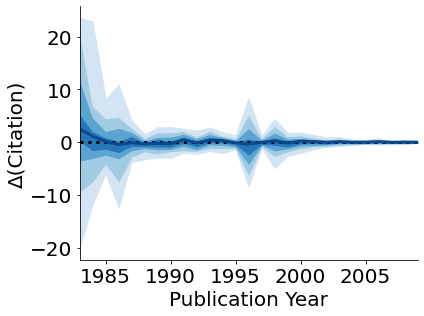

In [ ]:
fig, ax = plt.subplots(figsize=(6,4.5))
right_side = ax.spines["right"]
top_side = ax.spines["top"]
right_side.set_visible(False)
top_side.set_visible(False)

cm2 = sns.color_palette("Blues",10)

plt.axhline(y=0, color='black', linestyle='dotted', lw=3)
# sns.lineplot(data=mfpair, x="year", y='countd',ax=ax,ci=None,color="black")
plt.plot(mmpair.year,mmpair["median"],"-",label="M-M Median", color=cm2[9], lw=3)

plt.fill_between(mmpair.year, mmpair["percentile_10"], mmpair["percentile_20"], color=cm2[1])
plt.fill_between(mmpair.year, mmpair["percentile_20"], mmpair["percentile_30"], color=cm2[3])
plt.fill_between(mmpair.year, mmpair["percentile_30"], mmpair["percentile_40"], color=cm2[5])
plt.fill_between(mmpair.year, mmpair["percentile_40"], mmpair["median"], color=cm2[7])
plt.fill_between(mmpair.year, mmpair["median"], mmpair["percentile_60"], color=cm2[7])
plt.fill_between(mmpair.year, mmpair["percentile_60"], mmpair["percentile_70"], color=cm2[5])
plt.fill_between(mmpair.year, mmpair["percentile_70"], mmpair["percentile_80"], color=cm2[3])
plt.fill_between(mmpair.year, mmpair["percentile_80"], mmpair["percentile_90"], color=cm2[1])

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel("Publication Year", fontsize=20)
plt.ylabel("\u0394(Citation)", fontsize=20)

plt.xlim(xmin=1983, xmax=2009)

plt.tight_layout()
#fig.savefig(f"drive/My Drive/codes/mmpair.pdf")

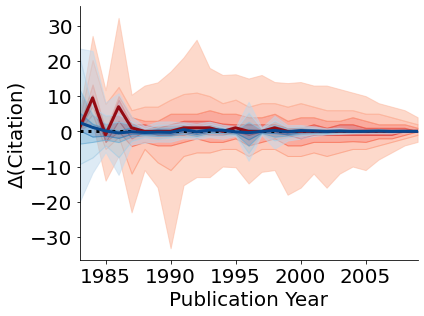

In [ ]:
fig, ax = plt.subplots(figsize=(6,4.5))
right_side = ax.spines["right"]
top_side = ax.spines["top"]
right_side.set_visible(False)
top_side.set_visible(False)

cm = sns.color_palette("Reds",10)

plt.axhline(y=0, color='black', linestyle='dotted', lw=3)
# sns.lineplot(data=mfpair, x="year", y='countd',ax=ax,ci=None,color="black")
plt.plot(mfpair.year,mfpair.countd["median"],"-",label="M-F Median", color=cm[9], lw=3)

plt.fill_between(mfpair.year, mfpair.countd["percentile_10"], mfpair.countd["percentile_20"], color=cm[2], alpha = 0.5)
plt.fill_between(mfpair.year, mfpair.countd["percentile_20"], mfpair.countd["percentile_30"], color=cm[3], alpha = 0.5)
plt.fill_between(mfpair.year, mfpair.countd["percentile_30"], mfpair.countd["percentile_40"], color=cm[5], alpha = 0.5)
plt.fill_between(mfpair.year, mfpair.countd["percentile_40"], mfpair.countd["median"], color=cm[7], alpha = 0.5)
plt.fill_between(mfpair.year, mfpair.countd["median"], mfpair.countd["percentile_60"], color=cm[7], alpha = 0.5)
plt.fill_between(mfpair.year, mfpair.countd["percentile_60"], mfpair.countd["percentile_70"], color=cm[5], alpha = 0.5)
plt.fill_between(mfpair.year, mfpair.countd["percentile_70"], mfpair.countd["percentile_80"], color=cm[3], alpha = 0.5)
plt.fill_between(mfpair.year, mfpair.countd["percentile_80"], mfpair.countd["percentile_90"], color=cm[2], alpha = 0.5)

cm2 = sns.color_palette("Blues",10)

plt.plot(mmpair.year,mmpair["median"],"-",label="M-M Median", color=cm2[9], lw=3)

plt.fill_between(mmpair.year, mmpair["percentile_10"], mmpair["percentile_20"], color=cm2[2], alpha = 0.5)
plt.fill_between(mmpair.year, mmpair["percentile_20"], mmpair["percentile_30"], color=cm2[3], alpha = 0.5)
plt.fill_between(mmpair.year, mmpair["percentile_30"], mmpair["percentile_40"], color=cm2[5], alpha = 0.5)
plt.fill_between(mmpair.year, mmpair["percentile_40"], mmpair["median"], color=cm2[7], alpha = 0.5)
plt.fill_between(mmpair.year, mmpair["median"], mmpair["percentile_60"], color=cm2[7], alpha = 0.5)
plt.fill_between(mmpair.year, mmpair["percentile_60"], mmpair["percentile_70"], color=cm2[5], alpha = 0.5)
plt.fill_between(mmpair.year, mmpair["percentile_70"], mmpair["percentile_80"], color=cm2[3], alpha = 0.5)
plt.fill_between(mmpair.year, mmpair["percentile_80"], mmpair["percentile_90"], color=cm2[2], alpha = 0.5)

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel("Publication Year", fontsize=20)
plt.ylabel("\u0394(Citation)", fontsize=20)

plt.xlim(xmin=1983, xmax=2009)

plt.tight_layout()
# fig.savefig(f"drive/My Drive/codes/paircomp.pdf")

In [ ]:
meanlist = final_df.iloc[:,1:].mean(axis=1).tolist()
sdlist = final_df.iloc[:,1:].std(axis=1).tolist()

final_df['avg'] = meanlist
final_df['sd'] = sdlist
final_df = final_df[['year','avg','sd']]

In [ ]:
test_df = plot_hom.groupby("year").agg(['count', np.mean, np.std]).reset_index()

In [ ]:
semlist = []

for i in range(len(test_df)):
  semlist.append(test_df.countd['std'][i]/math.sqrt(test_df.countd['count'][i]))

test_df['sem'] = semlist

#test_df.countd.sem = test_df.countd.std/math.sqrt(test_df.countd.count)
test_df

year countd                             sem
          count       mean        std          
0   1983      4   2.250000   3.201562  1.600781
1   1984      4  13.250000  14.591664  7.295832
2   1985     34  -2.529412  18.452618  3.164598
3   1986     73   8.232877  20.200055  2.364238
4   1987    107  -2.336449  34.303293  3.316225
5   1988    181   2.635359  20.506900  1.524266
6   1989    242  -0.016529  26.932830  1.731308
7   1990    239  -0.958159  32.462621  2.099832
8   1991    298   2.382550  25.605423  1.483282
9   1992    361   3.831025  21.148857  1.113098
10  1993    423   1.810875  17.303184  0.841310
11  1994    508   2.444882  20.142268  0.893669
12  1995    699   3.346209  21.790229  0.824182
13  1996    613  -0.065253  18.393635  0.742912
14  1997    696   1.701149  20.178051  0.764847
15  1998    800   3.005000  35.129226  1.242006
16  1999    924  -1.676407  18.976471  0.624280
17  2000   1144  -0.466783  18.450395  0.545497
18  2001   1488   1.430108  21.741693  0.563627
19  2002   1669  -6.052726  50.283509  1.230828
20  2003   1625  -0.501538  21.443422  0.531946
21  2004   2325  -0.797849  27.944845  0.579549
22  2005   2997  -1.057057  24.758185  0.452247
23  2006   3237   0.757183  12.837425  0.225635
24  2007   3785   0.203170   9.264363  0.150585
25  2008   5131   0.785617   8.541998  0.119250
26  2009   6192   0.610465   5.310766  0.067490

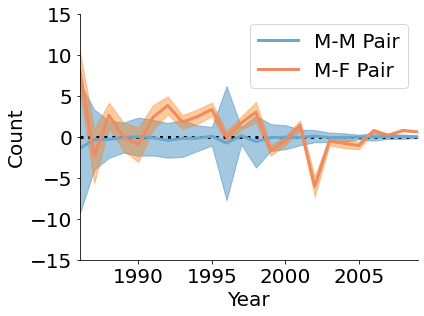

In [ ]:
fig, ax = plt.subplots(figsize=(6,4.5))
right_side = ax.spines["right"]
top_side = ax.spines["top"]
right_side.set_visible(False)
top_side.set_visible(False)

plt.axhline(y=0, color='black', linestyle='dotted', lw=3)

# plt.plot(final_df.year,final_df.avg,"-",label="M-M Pair", color='blue', lw=3)
plt.plot(final_df.year,final_df.avg,"-",label="M-M Pair", color='#67a9cf', lw=3)

X  = np.linspace(min(final_df.year),max(final_df.year),final_df.year.nunique())
plt.fill_between(X,
                 final_df.avg + final_df.sd,
                 final_df.avg - final_df.sd,
                 color='C0',alpha=.4,edgecolor="none")

#sns.lineplot(data=plot_hom, x="year", y="countd",ax=ax,ci=None,color="red", label='M-F', lw=3)

# plt.plot(test_df.year,test_df.countd['mean'],"-",label="M-F Pair", color='red', lw=3)
plt.plot(test_df.year,test_df.countd['mean'],"-",label="M-F Pair", color='#ef8a62', lw=3)

plt.fill_between(X,
                 test_df.countd['mean'] + test_df['sem'],
                 test_df.countd['mean'] - test_df['sem'],
                 color='C1',alpha=.4,edgecolor="none")

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel("Year",fontsize=20)
# plt.ylabel("\u0394(Citation)",fontsize=20)
plt.ylabel("Count",fontsize=20)
plt.xlim(xmin=1986, xmax=2009)
plt.ylim(ymin=-15, ymax=15)

plt.legend(loc='upper right', fontsize=20)

plt.tight_layout()
# fig.savefig(f"drive/My Drive/codes/se_comp.pdf")
fig.savefig(f"drive/My Drive/codes/se_comp_edit.pdf")

## 1d. PageRank Centrality Difference Trend

In [ ]:
# cdata = pd.read_csv('drive/My Drive/codes/cdata.csv')
cen = pd.read_csv('drive/My Drive/codes/cen.csv')

Graphtype = nx.DiGraph()

C = nx.from_pandas_edgelist(cen, source='citing_doi',
                            target='cited_doi', create_using=Graphtype)
print(nx.info(C))

Name: 
Type: DiGraph
Number of nodes: 144813
Number of edges: 703005
Average in degree:   4.8546
Average out degree:   4.8546


In [ ]:
# observe author id & gender (primary author)
nodedata = data.query('is_alpha == False & order == 1').drop(
    ['order', 'numAuthor',	'is_last',	'is_alpha',	'year',
     'articleType',	'journal', 'id'], axis=1).reset_index()
nodedata.columns = ['id', 'Label', 'Gender']
nodedata.tail()

,id,Label,Gender
149622,531302,10.1103/PhysRevLett.98.068101,male
149623,531304,10.1103/PhysRevE.76.017301,female
149624,531305,10.1103/PhysRevSTPER.3.020101,male
149625,531310,10.1103/PhysRevSTPER.4.010102,male
149626,531311,10.1103/PhysRevSTPER.4.010108,male


In [ ]:
# assign PageRank centrality to each paper
pr = nx.pagerank(C)

# create a centrality dataframe
prs = pd.DataFrame()
prs['doi'] = pr.keys()
prs['centrality'] = pr.values()

# merge and create a dataframe: id, gender, PageRank centrality
prs_new = prs.merge(nodedata, left_on='doi', right_on='Label',
                how='left').drop(['doi', 'Label'], axis=1)
prs_new = prs_new[['id', 'Gender', 'centrality']].sort_values(
    'centrality', ascending=False)
prs_new.head()

,id,Gender,centrality
3189,43633,male,0.001368
25816,87360,male,0.001325
49819,187598,male,0.001062
54770,187575,male,0.000961
20116,91551,male,0.000918


In [ ]:
# Calculate cen_d (male centrality - female centrality)

prs_sim = prs.merge(nodedata, left_on='doi', right_on='Label',
                    how='left').drop(['Label'], axis=1)
prs_sim = prs_sim[["doi", 'id', 'Gender', 'centrality']].sort_values(
    'centrality', ascending=False)

ph = pd.merge(pair, prs_sim, left_on = "paper1", right_on = "doi", how = "left")
ph = ph.drop(["doi", "id", "Gender"], axis=1)
ph = ph.rename(columns={"centrality": "cen1"})

ph = ph.merge(prs_sim, left_on = "paper2", right_on = "doi", how = "left")
ph = ph.drop(["doi", "id", "Gender"], axis=1)
ph = ph.rename(columns={"centrality": "cen2"})
print(len(ph))

ph = ph[ph['gender1'] != ph['gender2']].reset_index(drop=True)

listc = []

for j in range(len(ph)):
  listc.append(max(ph['year1'][j], ph['year2'][j]))

ph['year'] = listc

listd = []
listy = []

for c in range(len(ph)):
  if ph['gender1'][c] == 'male':
    listd.append(ph['cen1'][c] - ph['cen2'][c])
    listy.append(ph['year1'][c] - ph['year2'][c])
  else:
    listd.append(ph['cen2'][c] - ph['cen1'][c])
    listy.append(ph['year2'][c] - ph['year1'][c])

ph['cen_d'] = listd
ph['yeard'] = listy

print(len(ph))
ph.head()

5856207
991845


,paper1,gender1,year1,paper2,gender2,year2,qval,k,cen1,cen2,year,cen_d,yeard
0,10.1103/PhysRevA.30.336,male,1984,10.1103/PhysRevA.34.4472,female,1986,0.017857,False,0.000018,0.000004,1986,1.402271e-05,-2
1,10.1103/PhysRevA.34.4472,female,1986,10.1103/PhysRevA.41.784,male,1990,0.017857,False,0.000004,0.000005,1990,7.764608e-07,4
2,10.1103/PhysRevA.36.4950,female,1987,10.1103/PhysRevA.41.784,male,1990,0.006410,False,0.000002,0.000005,1990,2.824713e-06,3
3,10.1103/PhysRevA.39.5466,female,1989,10.1103/PhysRevA.41.784,male,1990,0.006410,False,0.000002,0.000005,1990,2.166712e-06,1
4,10.1103/PhysRevA.41.3081,female,1990,10.1103/PhysRevA.41.784,male,1990,0.000511,False,0.000002,0.000005,1990,2.824713e-06,0


In [ ]:
ph = ph[ph['yeard'] > -4].sort_values('yeard').reset_index(drop=True)
ph = ph[ph['yeard'] < 4].sort_values('yeard').reset_index(drop=True)

In [ ]:
# Extract subDataFrame with q-value less than p threshold

p = 0.002 # Select p thresholds with listed numbers in the paper

phsub = ph[ph['qval'] < p].sort_values('cen_d').reset_index(drop=True)

mlist = []
fmlist = []

for i in range(len(phsub)):
  if phsub['gender1'][i] == 'male':
    mlist.append(phsub['cen1'][i])
    fmlist.append(phsub['cen2'][i])
  else:
    mlist.append(phsub['cen2'][i])
    fmlist.append(phsub['cen1'][i])

print(len(phsub)/len(ph))
phsub.head()

0.06485455326102513


,paper1,gender1,year1,paper2,gender2,year2,qval,k,cen1,cen2,year,cen_d,yeard
0,10.1103/PhysRevE.70.021913,male,2004,10.1103/RevModPhys.74.47,female,2002,0.001534,False,0.000002,0.000291,2004,-0.000289,2
1,10.1103/PhysRevE.69.066105,male,2004,10.1103/RevModPhys.74.47,female,2002,0.001672,True,0.000002,0.000291,2004,-0.000289,2
2,10.1103/PhysRevE.72.061901,male,2005,10.1103/RevModPhys.74.47,female,2002,0.000922,True,0.000002,0.000291,2005,-0.000289,3
3,10.1103/PhysRevE.66.036128,male,2002,10.1103/RevModPhys.74.47,female,2002,0.000450,True,0.000002,0.000291,2002,-0.000289,0
4,10.1103/PhysRevE.64.047103,male,2001,10.1103/RevModPhys.74.47,female,2002,0.001057,False,0.000002,0.000291,2002,-0.000289,-1


In [ ]:
plot_ph = phsub[['year', 'cen_d']].sort_values(by=['year', 'cen_d'])
plot_ph['normalized'] = plot_ph['cen_d'].div(plot_ph['cen_d'].abs().groupby(
    plot_ph['year']).transform('max'))
# plot_hom['gender'] = ['male' if x >=0 else 'female' for x in plot_hom['countd']]

print(len(plot_ph))
plot_ph.head()

35799


,year,cen_d,normalized
10383,1983,-3.664231e-07,-0.040247
26617,1983,6.426475e-07,0.070587
26618,1983,6.426475e-07,0.070587
35045,1983,9.104276e-06,1.000000
32590,1984,2.462086e-06,0.100543


Text(0, 0.5, 'Δ(Citation)')

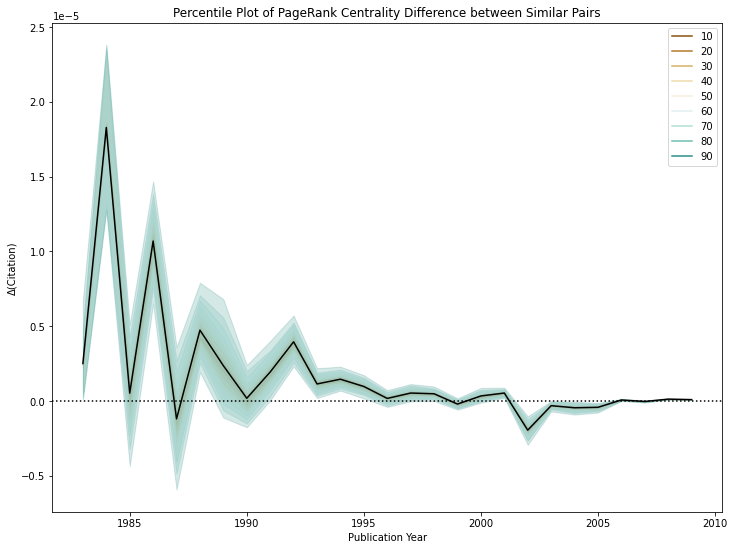

In [ ]:
fig,ax = plt.subplots(1,1, figsize=[12,9])

plt.axhline(y=0, color='black', linestyle='dotted')
sns.lineplot(data=plot_ph, x="year", y="cen_d",ax=ax,ci=None,color="black")

cm = sns.color_palette("BrBG",10)

for ix,ci in enumerate(range(10,100,10)):
    sns.lineplot(data=plot_ph, x="year", y="cen_d",
                 ci = ci,
                 ax=ax,linestyle='',
                 hue = ci,palette={ci:cm[ix]})

plt.title("Percentile Plot of PageRank Centrality Difference between Similar Pairs")
plt.xlabel("Publication Year")
plt.ylabel("\u0394(Citation)")

In [ ]:
mwu3 = plot_ph[plot_ph['year'] <= 1995]
mwu4 = plot_ph[plot_ph['year'] > 1995]

scipy.stats.mannwhitneyu(mwu3.cen_d, mwu4.cen_d)

MannwhitneyuResult(statistic=48270565.5, pvalue=1.655998477224141e-10)

# 2a. Gender citing gender (setup)

In [ ]:
def cit_count(g):

    # count x2-> y2 pairs
    df1 = g.drop_duplicates(subset=['cit1', 'paper1', 'pair'])
    c1 = (df1['cgen1'] + '_' + df1['gender1']).value_counts()

    # count x2-> y2 pairs
    df2 = g.drop_duplicates(subset=['cit2', 'paper2', 'pair'])
    c2 = (df2['cgen2'] + '_' + df2['gender2']).value_counts()

    # add results
    return c1.add(c2, fill_value=0)

In [ ]:
############## SELECT DESIRED PACS (HOMOPHILY ONLY) ###############

# homn = pd.read_csv("drive/My Drive/codes/hom0.csv")
# homn = pd.read_csv("drive/My Drive/codes/hom1.csv")
# homn = pd.read_csv("drive/My Drive/codes/hom2.csv")
# homn = pd.read_csv("drive/My Drive/codes/hom3.csv")
# homn = pd.read_csv("drive/My Drive/codes/hom4.csv")
# homn = pd.read_csv("drive/My Drive/codes/hom5.csv")
# homn = pd.read_csv("drive/My Drive/codes/hom6.csv")
# homn = pd.read_csv("drive/My Drive/codes/hom7.csv")
# homn = pd.read_csv("drive/My Drive/codes/hom8.csv")
homn = pd.read_csv("drive/My Drive/codes/hom9.csv")

time: 892 ms (started: 2021-03-30 06:44:46 +00:00)


In [ ]:
hom = homn.drop(['year1', 'year2', 'k'], axis=1)

cen = cen.rename({'citing_doi': 'cit', 'citing_gender': 'cgender',
                          'cited_doi': 'paper', 'cited_gender': 'pgender'},
                          axis=1)

hom = hom[hom['gender1'] != hom['gender2']]

time: 62.9 ms (started: 2021-03-30 06:44:48 +00:00)


In [ ]:
# DataFrame: cit1 cites paper1, cit2 cites paper2
# where paper1 and paper 2 are similar pairs

test = pd.merge(cen, hom, left_on='paper', right_on='paper1',
                how='inner').drop(['paper', 'pgender'], axis=1).rename(
                    {'cit': 'cit1', 'cgender': 'cgen1'}, axis=1)

test = test.merge(cen, left_on='paper2',
                  right_on='paper', how='inner').drop(
                      ['paper', 'pgender'], axis=1).rename(
                          {'cit': 'cit2', 'cgender': 'cgen2'}, axis=1)
test = test[['cit1', 'cgen1', 'cit2', 'cgen2', 'paper1', 'gender1', 'paper2',
             'gender2', 'qval']]

print(len(test))
test.head()

731817


,cit1,cgen1,cit2,cgen2,paper1,gender1,paper2,gender2,qval
0,10.1103/PhysRevD.79.103502,male,10.1103/PhysRevD.77.063511,female,10.1103/PhysRevD.70.103518,male,10.1103/PhysRevD.77.063510,female,0.032609
1,10.1103/PhysRevD.79.103502,male,10.1103/PhysRevD.77.063510,female,10.1103/PhysRevD.70.103518,male,10.1103/PhysRevD.77.063510,female,0.032609
2,10.1103/RevModPhys.78.537,male,10.1103/PhysRevD.77.063511,female,10.1103/PhysRevD.70.103518,male,10.1103/PhysRevD.77.063510,female,0.032609
3,10.1103/RevModPhys.78.537,male,10.1103/PhysRevD.77.063510,female,10.1103/PhysRevD.70.103518,male,10.1103/PhysRevD.77.063510,female,0.032609
4,10.1103/PhysRevD.77.023514,male,10.1103/PhysRevD.77.063511,female,10.1103/PhysRevD.70.103518,male,10.1103/PhysRevD.77.063510,female,0.032609


time: 607 ms (started: 2021-03-30 06:44:50 +00:00)


In [ ]:
test['pair'] = test.groupby(['paper1', 'paper2']).ngroup()
test = test.sort_values(['pair','cit1','cit2'])

print(test.pair.nunique())
test.head()

13632


,cit1,cgen1,cit2,cgen2,paper1,gender1,paper2,gender2,qval,pair
48018,10.1103/PhysRevA.46.3413,male,10.1103/PhysRevD.65.063004,female,10.1103/PhysRevA.42.3587,male,10.1103/PhysRevD.56.3296,female,0.009174,0
48019,10.1103/PhysRevA.46.3413,male,10.1103/PhysRevD.77.043529,male,10.1103/PhysRevA.42.3587,male,10.1103/PhysRevD.56.3296,female,0.009174,0
48020,10.1103/PhysRevA.46.3413,male,10.1103/PhysRevLett.82.4835,female,10.1103/PhysRevA.42.3587,male,10.1103/PhysRevD.56.3296,female,0.009174,0
48024,10.1103/PhysRevD.48.5655,male,10.1103/PhysRevD.65.063004,female,10.1103/PhysRevA.42.3587,male,10.1103/PhysRevD.56.3296,female,0.009174,0
48025,10.1103/PhysRevD.48.5655,male,10.1103/PhysRevD.77.043529,male,10.1103/PhysRevA.42.3587,male,10.1103/PhysRevD.56.3296,female,0.009174,0


time: 600 ms (started: 2021-03-30 06:44:53 +00:00)


In [ ]:
genco = test.groupby('pair').apply(cit_count).unstack().fillna(0).astype(int)

time: 1min 26s (started: 2021-03-30 06:44:56 +00:00)


In [ ]:
# genco.to_csv(r'drive/My Drive/codes/genco00.csv',index=False)
# genco.to_csv(r'drive/My Drive/codes/genco10.csv',index=False)
# genco.to_csv(r'drive/My Drive/codes/genco20.csv',index=False)
# genco.to_csv(r'drive/My Drive/codes/genco30.csv',index=False)
# genco.to_csv(r'drive/My Drive/codes/genco40.csv',index=False)
# genco.to_csv(r'drive/My Drive/codes/genco50.csv',index=False)
# genco.to_csv(r'drive/My Drive/codes/genco60.csv',index=False)
# genco.to_csv(r'drive/My Drive/codes/genco70.csv',index=False)
# genco.to_csv(r'drive/My Drive/codes/genco80.csv',index=False)
genco.to_csv(r'drive/My Drive/codes/genco90.csv',index=False)

time: 32.7 ms (started: 2021-03-30 06:46:22 +00:00)


# 2b. Gender citing gender

In [ ]:
############## SELECT DESIRED PACS (HOMOPHILY ONLY) ###############

# genco = pd.read_csv("drive/My Drive/codes/genco00.csv")
# genco = pd.read_csv("drive/My Drive/codes/genco10.csv")
# genco = pd.read_csv("drive/My Drive/codes/genco20.csv")
# genco = pd.read_csv("drive/My Drive/codes/genco30.csv")
# genco = pd.read_csv("drive/My Drive/codes/genco40.csv")
# genco = pd.read_csv("drive/My Drive/codes/genco50.csv")
# genco = pd.read_csv("drive/My Drive/codes/genco60.csv")
# genco = pd.read_csv("drive/My Drive/codes/genco70.csv")
# genco = pd.read_csv("drive/My Drive/codes/genco80.csv")
genco = pd.read_csv("drive/My Drive/codes/genco90.csv")

time: 16.4 ms (started: 2021-03-30 07:21:34 +00:00)


In [ ]:
genco['M'] = genco['male_male'] / (
    genco['male_male'] + genco['male_female'])
genco['F'] = genco['female_female'] / (
    genco['female_male'] + genco['female_female'])
genco = genco.fillna(0)

time: 9.02 ms (started: 2021-03-30 07:13:33 +00:00)


In [ ]:
print(statistics.mean(genco['M']))
print(scipy.stats.sem(genco['M'], axis=None))
print(statistics.mean(genco['F']))
print(scipy.stats.sem(genco['F'], axis=None))

0.5764143237420447
0.002423995004531813
0.5052111363062443
0.0037250616225795383
time: 42.8 ms (started: 2021-03-30 07:13:33 +00:00)


# 2c. Overall GCG Statistics

In [ ]:
genco0 = pd.read_csv("drive/My Drive/codes/genco00.csv")
genco1 = pd.read_csv("drive/My Drive/codes/genco10.csv")
genco2 = pd.read_csv("drive/My Drive/codes/genco20.csv")
genco3 = pd.read_csv("drive/My Drive/codes/genco30.csv")
genco4 = pd.read_csv("drive/My Drive/codes/genco40.csv")
genco5 = pd.read_csv("drive/My Drive/codes/genco50.csv")
genco6 = pd.read_csv("drive/My Drive/codes/genco60.csv")
genco7 = pd.read_csv("drive/My Drive/codes/genco70.csv")
genco8 = pd.read_csv("drive/My Drive/codes/genco80.csv")
genco9 = pd.read_csv("drive/My Drive/codes/genco90.csv")

time: 193 ms (started: 2021-03-30 07:02:06 +00:00)


In [ ]:
genco_n = pd.concat([genco0, genco1, genco2, genco3, genco4, genco5,
                     genco6, genco7, genco8, genco9])
genco_n.head()

,female_female,female_male,male_female,male_male
0,1,0,1,5
1,0,0,3,22
2,1,0,0,3
3,1,0,0,24
4,1,0,0,4


time: 29.7 ms (started: 2021-03-30 07:02:35 +00:00)


In [ ]:
genco_n['M'] = genco_n['male_male'] / (
    genco_n['male_male'] + genco_n['male_female'])
genco_n['F'] = genco_n['female_female'] / (
    genco_n['female_male'] + genco_n['female_female'])
genco_n = genco_n.fillna(0)

time: 47.1 ms (started: 2021-03-30 07:03:58 +00:00)


In [ ]:
print(statistics.mean(genco_n['M']))
print(statistics.stdev(genco_n['M']))
print(scipy.stats.sem(genco_n['M'], axis=None))
print(statistics.mean(genco_n['F']))
print(statistics.stdev(genco_n['F']))
print(scipy.stats.sem(genco_n['F'], axis=None))

0.579407368379222
0.29992456395122274
0.00038316824833655924
0.5473017630052013
0.4437672136252252
0.0005669342439775178
time: 4.58 s (started: 2021-03-30 07:03:59 +00:00)
